In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from transformers import AutoTokenizer
import pickle
import os
from MLP import ProtDataModule, SeqFcnDataset, MLP
from torchtext import vocab # This package can give problems sometimes, it may be necessary to downgrade to a specific version
from collections import OrderedDict
import torch
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.special import softmax
from functions import (load_vae_model, load_reward_model, find_closest_average_hd, generate_and_evaluate_mutants_2, generate_and_evaluate_mutants_vae_training,
    decoding, Using_VAE, hamming_distance_vae_training, ProtDataModule, ProtRepDataset, adjust_designs, SeqDataset, convert_and_score_sequences,
    save_metrics_to_csv, identify_mutations, save_sorted_designs_to_csv)
import torch.nn.functional as F
import umap
from conv_vae_model import ConvVAE


In [2]:
# Define amino acid dictionary for tokenization, define WT for length of context window
AAs = 'ACDEFGHIKLMNPQRSTVWY' # setup torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))
WT = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA' # CreiLOV
Natural_CreiLOV = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNCRFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'
sequence_length = len(WT)
model_identifier ='esm2_t33_650M_UR50D'
tokenizer = AutoTokenizer.from_pretrained(f"facebook/{model_identifier}")
num_models = 100
aa2ind = vocab.vocab(OrderedDict([(a, 1) for a in AAs]))
aa2ind.set_default_index(20) # set unknown charcterers to gap


In [3]:
def get_msa_from_fasta(filename):
    import Bio.SeqIO
    with open(filename, "rt") as fh: 
        return [r[1] for r in Bio.SeqIO.FastaIO.SimpleFastaParser(fh)]

Magma_r = plt.cm.magma_r(np.linspace(0, 1, 256))
Magma_r[0] = [0, 0, 0, 0.03]  # fade zero to white
cmap = LinearSegmentedColormap.from_list("Modified_Magma_r", Magma_r, N=256)


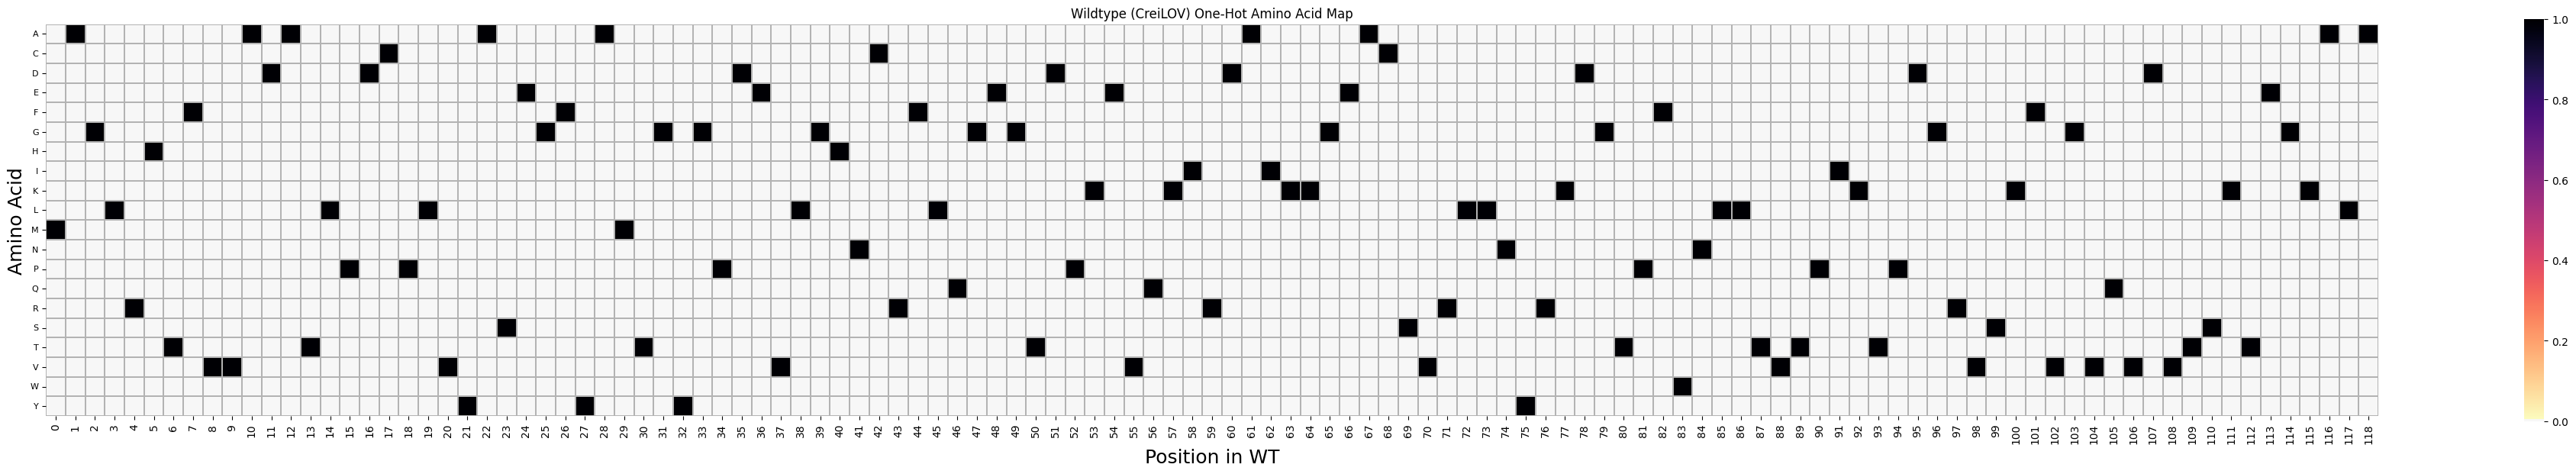

In [4]:
# Create empty 20 x L matrix
wt_matrix = np.zeros((20, len(WT)))

# Fill in 1 at the WT amino acid at each position
for pos, aa in enumerate(Natural_CreiLOV):
    if aa in AAs:  # Only place a 1 if the AA is valid
        aa_idx = AAs.index(aa)
        wt_matrix[aa_idx, pos] = 1

# Save the WT one-hot matrix
np.save('figures/Natural_CreiLOV.npy', wt_matrix)

# Plot heatmap
plt.figure(figsize=(len(WT) // 3, 6))
sns.heatmap(wt_matrix, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7', vmin=0, vmax=1)

plt.yticks(np.arange(len(AAs)) + 0.5, list(AAs), fontsize=8, rotation=0)
plt.xlabel("Position in WT", fontsize=18)
plt.ylabel("Amino Acid", fontsize=18)
plt.title("Wildtype (CreiLOV) One-Hot Amino Acid Map")
plt.tight_layout()

# Save plot
plt.savefig('figures/Natural_CreiLOV.png', dpi=300)
plt.savefig('figures/Natural_CreiLOV.svg')
plt.show()

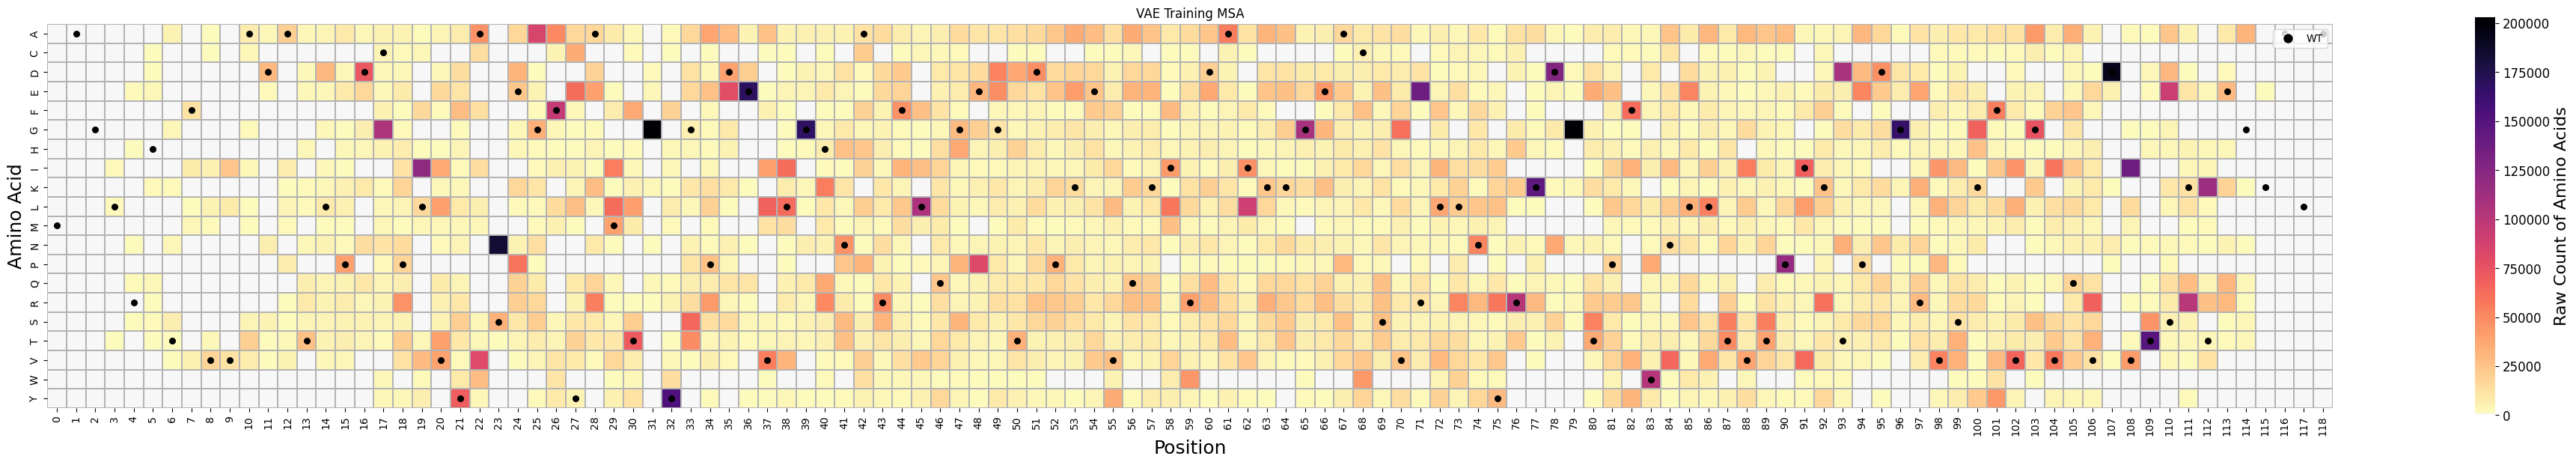

In [5]:
# # MSA training split used to train VAE
# MSA = get_msa_from_fasta("../RLXF_Projects/data/for_vae/CreiLOV_MSA_UniRef90_2.fasta")
# splits_filename = "../RLXF_Projects/data/for_vae/CreiLOV_MSA_data_splits.pkl"
# with open(splits_filename, "rb") as f:
#     train_idx, val_idx, test_idx = pickle.load(f)
# training_df = pd.DataFrame({'Sequence': [MSA[i] for i in train_idx]})

# # Count AAs per position across training sequences for all amino acids (ignore gap -)
# alignment = tuple(zip(*training_df.Sequence))
# AA_count = np.array([[sum(1 for aa_at_pos in alignment[pos] if aa_at_pos == aa) for aa in AAs] for pos in range(len(WT))])  # shape: (L, 20)
# AA_count = AA_count.T
# # AA_count = softmax(AA_count, axis=0)  # AA-wise softmax per position

# # Plot heatmap
# plt.figure(figsize=(len(WT) // 3, 6))
# heatmap = sns.heatmap(AA_count, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')
# cbar = heatmap.collections[0].colorbar
# cbar.set_label('Raw Count of Amino Acids', fontsize=16)
# cbar.ax.tick_params(labelsize=12)
# pos = cbar.ax.get_position()
# cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
# plt.yticks(np.arange(len(AAs)) + 0.5, AAs)
# plt.xlabel('Position', fontsize=18)
# plt.ylabel('Amino Acid', fontsize=18)
# plt.title("VAE Training MSA")

# # Annotate WT positions with black dots
# for pos, aa in enumerate(WT):
#     if aa in AAs:
#         aa_index = AAs.index(aa)
#         plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
# plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')],
#            loc='upper right')

# # Save and show
# plt.tight_layout()
# plt.savefig("figures/CreiLOV_training_msa_mutation_heatmap.png", dpi=300)
# plt.show()
# # plt.close()

# # save the matrix
# AA_count_df = pd.DataFrame(AA_count)
# np.save("figures/MSA_training_amino_acid_count_matrix.npy", AA_count)


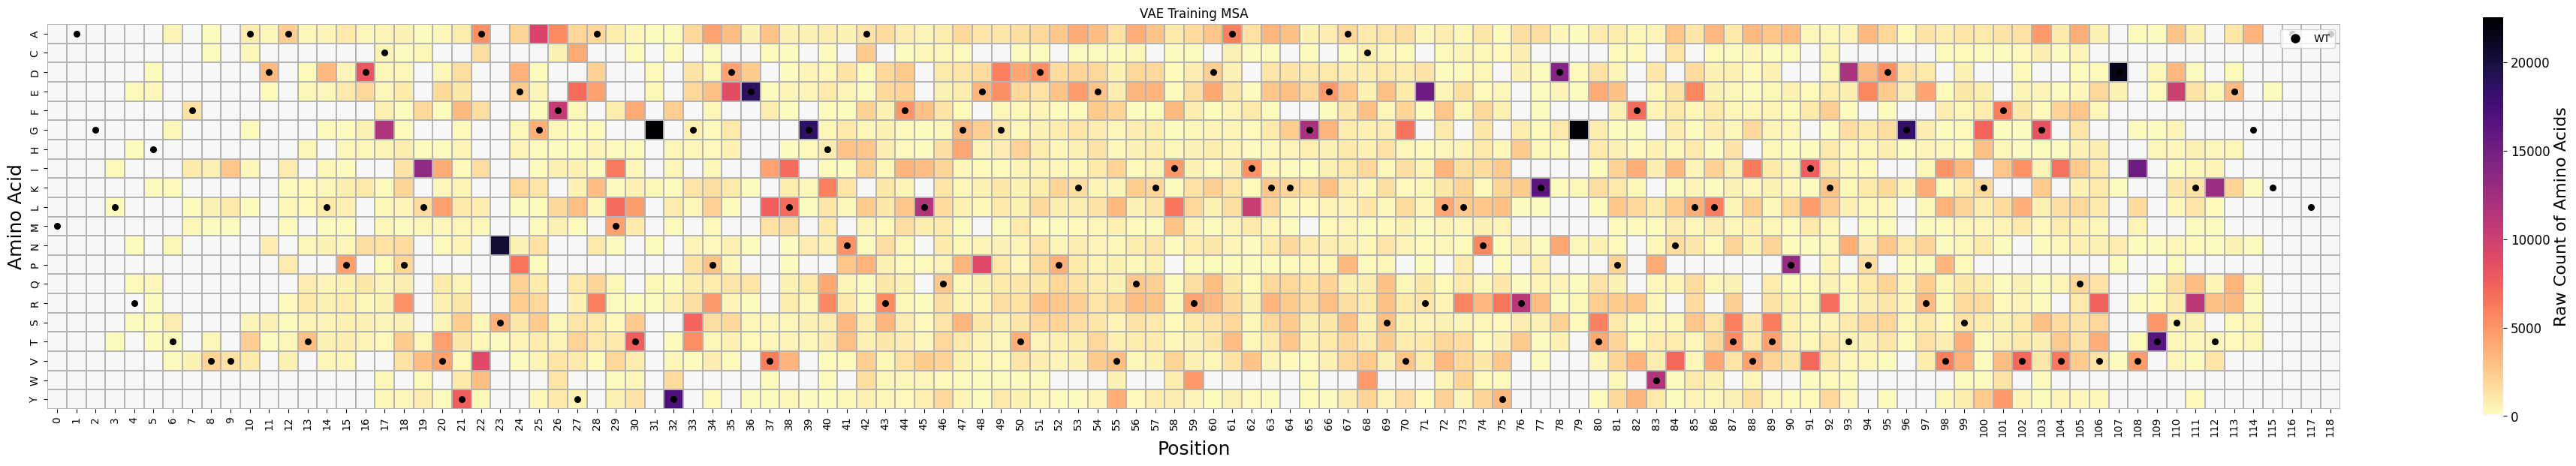

In [6]:
# # MSA training split used to train VAE
# MSA = get_msa_from_fasta("../RLXF_Projects/data/for_vae/CreiLOV_MSA_UniRef90_2.fasta")
# splits_filename = "../RLXF_Projects/data/for_vae/CreiLOV_MSA_data_splits.pkl"
# with open(splits_filename, "rb") as f:
#     train_idx, val_idx, test_idx = pickle.load(f)
# training_df = pd.DataFrame({'Sequence': [MSA[i] for i in val_idx]})

# # Count AAs per position across training sequences for all amino acids (ignore gap -)
# alignment = tuple(zip(*training_df.Sequence))
# AA_count = np.array([[sum(1 for aa_at_pos in alignment[pos] if aa_at_pos == aa) for aa in AAs] for pos in range(len(WT))])  # shape: (L, 20)
# AA_count = AA_count.T
# # AA_count = softmax(AA_count, axis=0)  # AA-wise softmax per position

# # Plot heatmap
# plt.figure(figsize=(len(WT) // 3, 6))
# heatmap = sns.heatmap(AA_count, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')
# cbar = heatmap.collections[0].colorbar
# cbar.set_label('Raw Count of Amino Acids', fontsize=16)
# cbar.ax.tick_params(labelsize=12)
# pos = cbar.ax.get_position()
# cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
# plt.yticks(np.arange(len(AAs)) + 0.5, AAs)
# plt.xlabel('Position', fontsize=18)
# plt.ylabel('Amino Acid', fontsize=18)
# plt.title("VAE Training MSA")

# # Annotate WT positions with black dots
# for pos, aa in enumerate(WT):
#     if aa in AAs:
#         aa_index = AAs.index(aa)
#         plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
# plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')],
#            loc='upper right')

# # Save and show
# plt.tight_layout()
# plt.savefig("figures/CreiLOV_val_msa_mutation_heatmap.png", dpi=300)
# plt.show()
# # plt.close()

# # save the matrix
# AA_count_df = pd.DataFrame(AA_count)
# np.save("figures/MSA_val_amino_acid_count_matrix.npy", AA_count)


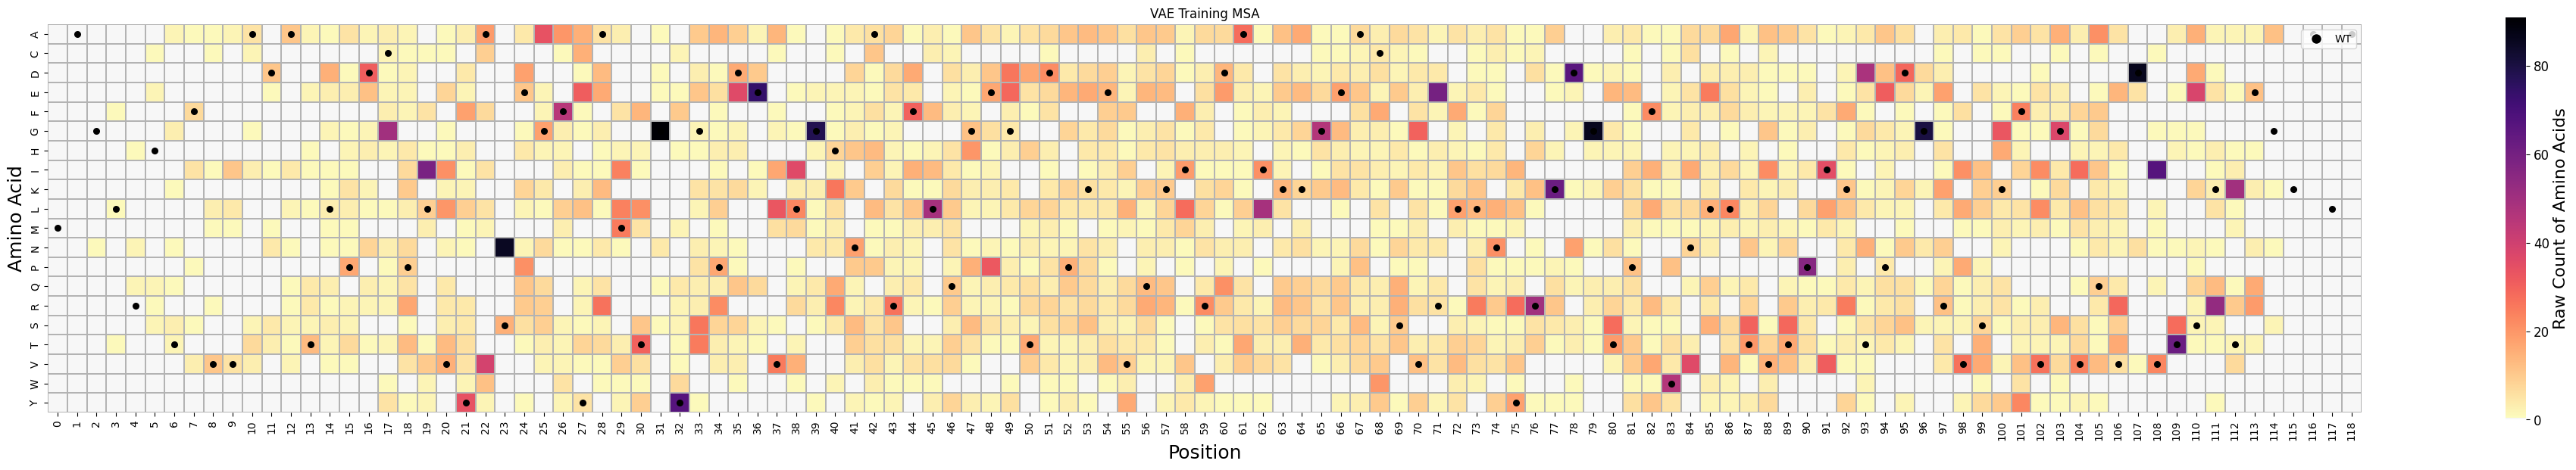

In [7]:
# # MSA training split used to train VAE
# MSA = get_msa_from_fasta("../RLXF_Projects/data/for_vae/CreiLOV_MSA_UniRef90_2.fasta")
# splits_filename = "../RLXF_Projects/data/for_vae/CreiLOV_MSA_data_splits.pkl"
# with open(splits_filename, "rb") as f:
#     train_idx, val_idx, test_idx = pickle.load(f)
# training_df = pd.DataFrame({'Sequence': [MSA[i] for i in test_idx]})

# # Count AAs per position across training sequences for all amino acids (ignore gap -)
# alignment = tuple(zip(*training_df.Sequence))
# AA_count = np.array([[sum(1 for aa_at_pos in alignment[pos] if aa_at_pos == aa) for aa in AAs] for pos in range(len(WT))])  # shape: (L, 20)
# AA_count = AA_count.T
# # AA_count = softmax(AA_count, axis=0)  # AA-wise softmax per position

# # Plot heatmap
# plt.figure(figsize=(len(WT) // 3, 6))
# heatmap = sns.heatmap(AA_count, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')
# cbar = heatmap.collections[0].colorbar
# cbar.set_label('Raw Count of Amino Acids', fontsize=16)
# cbar.ax.tick_params(labelsize=12)
# pos = cbar.ax.get_position()
# cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
# plt.yticks(np.arange(len(AAs)) + 0.5, AAs)
# plt.xlabel('Position', fontsize=18)
# plt.ylabel('Amino Acid', fontsize=18)
# plt.title("VAE Training MSA")

# # Annotate WT positions with black dots
# for pos, aa in enumerate(WT):
#     if aa in AAs:
#         aa_index = AAs.index(aa)
#         plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
# plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')],
#            loc='upper right')

# # Save and show
# plt.tight_layout()
# plt.savefig("figures/CreiLOV_test_msa_mutation_heatmap.png", dpi=300)
# plt.show()
# # plt.close()

# # save the matrix
# AA_count_df = pd.DataFrame(AA_count)
# np.save("figures/MSA_test_amino_acid_count_matrix.npy", AA_count)


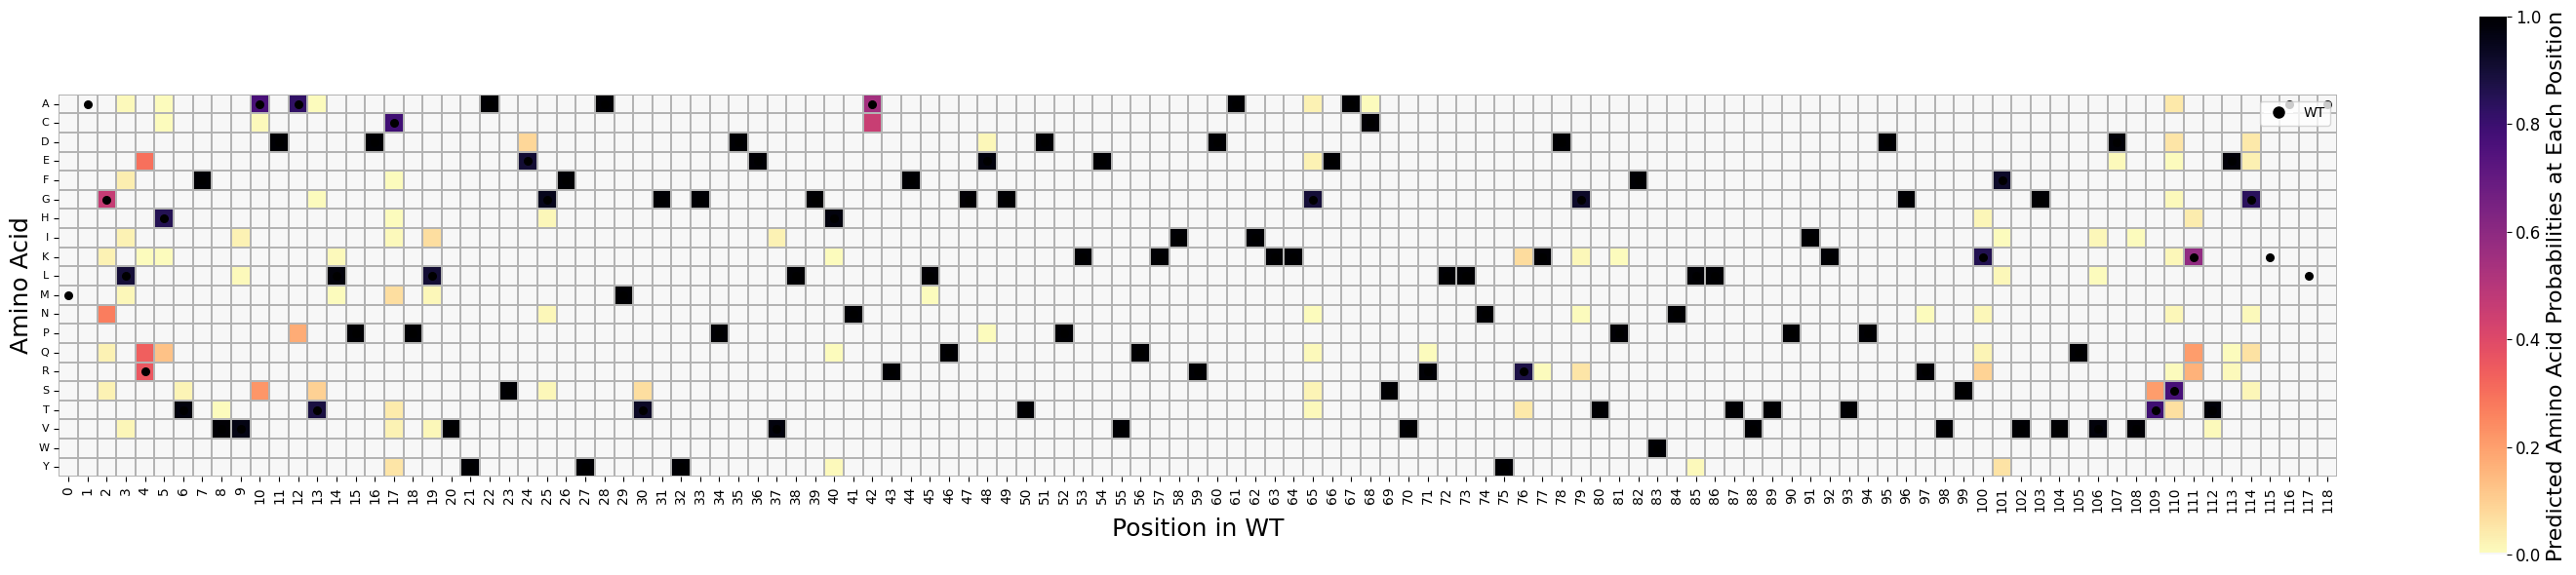

In [8]:
# load generative models
checkpoint_path = "../RLXF_Projects/saved_models/Best_ConvVAE.ckpt"
vae = ConvVAE.load_from_checkpoint(checkpoint_path)

# fix parameters in vae_fixed_model
for param in vae.parameters():
    param.requires_grad = False

# Compute Log Probability
def compute_probabilities_from_batch(batch, model):
    """
    Adapted from: ...
    Computes the cross-entropy loss scores for a given batch of sequences using a pre-trained neural network model.
    Args:
        batch (torch.Tensor): A LongTensor of shape (b, L) with
            b = batch size
            L = sequence length.
        model (torch.nn.Module): A pre-trained neural network model that takes in a batch of sequences and returns
            four tensors: z_mean, z_log_var, encoded, and decoded.
    Returns:
        scores (torch.Tensor): A 1D tensor of shape (b,) containing the cross-entropy loss scores for each sequence in
            the batch.
    """
    with torch.no_grad():  # We do not want training to occur during scoring
        z_mean, z_log_var, encoded, decoded = model(batch)
        logits = model.decoder(z_mean)  # Use z_mean instead of encoded to remove stochastic reparameterization
        probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return logits, probabilities

# Function to generate heatmap
def generate_heatmap(WT, vae):
    '''
    receives WT string
    '''
    WT_tensor_w_batch_dim = torch.tensor(aa2ind(list(WT))).unsqueeze(0)
    logits, probabilities = compute_probabilities_from_batch(WT_tensor_w_batch_dim, vae)
    probabilities = probabilities.squeeze(0).numpy()  # Reshape for heatmap
    probabilities = probabilities[:20, :]  # keep only AAs, exclude gap or special tokens
    
    # Plot heatmap
    plt.figure(figsize=(30, 6))
    heatmap = sns.heatmap(probabilities, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7', vmin=0, vmax=1)
    
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Predicted Amino Acid Probabilities at Each Position', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
    pos = cbar.ax.get_position()
    cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    
    plt.yticks(np.arange(len(AAs)) + 0.5, list(AAs), fontsize=8, rotation=0)
    plt.xlabel("Position in WT", fontsize=18)
    plt.ylabel('Amino Acid', fontsize=18)
    
    # Add black dots for WT sequence
    for pos, aa in enumerate(WT):
        aa_index = AAs.index(aa)
        plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
    
    legend_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10)
    plt.legend([legend_handle], ['WT'], loc='upper right')
    
    plt.tight_layout()
    np.save("figures/VAE_prob_matrix.npy", probabilities)
    plt.savefig('VAE_amino_acid_probabilities_heatmap.png')
    plt.savefig('VAE_amino_acid_probabilities_heatmap.svg')
    plt.show()

# Create amino acid probabilities for CreiLOV
generate_heatmap(WT, vae)


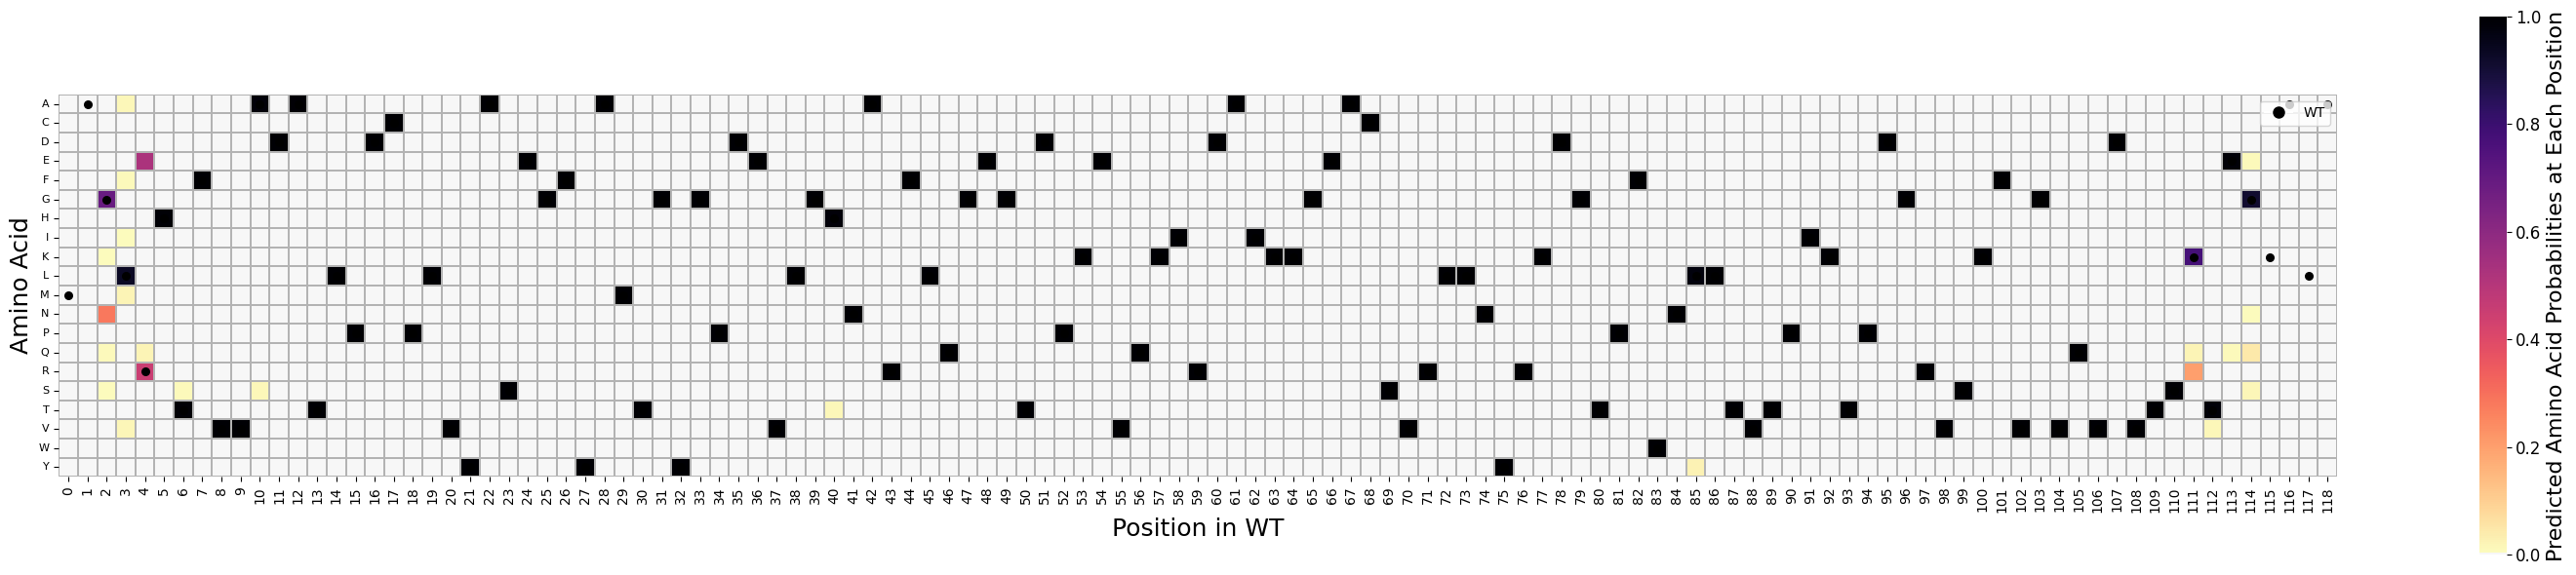

In [9]:
# Define hyperparameters again exactly as used during training
batch_size = 32
ks = 17
nlatent = 64
epochs = 1000
learning_rate = 0.0001
slen = len(WT)    # WT must be loaded or defined before this
n_cycle = 1
factor_2 = 16
factor_3 = 1
dim_4 = 400

# Load aligned vae
vae = ConvVAE(
    slen=slen,
    ks=ks,
    nlatent=nlatent,
    learning_rate=learning_rate,
    epochs=epochs,
    n_cycle=n_cycle,
    factor_2=factor_2,
    factor_3=factor_3,
    dim_4=dim_4,
)
checkpoint_path = "../RLXF_Projects/trained_models/vaes/rl_updated_vae_version_507.pt"
state_dict = torch.load(checkpoint_path, map_location='cpu')
vae.load_state_dict(state_dict)
vae.eval()

# Compute Log Probability
def compute_probabilities_from_batch(batch, model):
    """
    Adapted from: ...
    Computes the cross-entropy loss scores for a given batch of sequences using a pre-trained neural network model.
    Args:
        batch (torch.Tensor): A LongTensor of shape (b, L) with
            b = batch size
            L = sequence length.
        model (torch.nn.Module): A pre-trained neural network model that takes in a batch of sequences and returns
            four tensors: z_mean, z_log_var, encoded, and decoded.
    Returns:
        scores (torch.Tensor): A 1D tensor of shape (b,) containing the cross-entropy loss scores for each sequence in
            the batch.
    """
    with torch.no_grad():  # We do not want training to occur during scoring
        z_mean, z_log_var, encoded, decoded = model(batch)
        logits = model.decoder(z_mean)  # Use z_mean instead of encoded to remove stochastic reparameterization
        probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return logits, probabilities

# Function to generate heatmap
def generate_heatmap(WT, vae):
    '''
    receives WT string
    '''
    WT_tensor_w_batch_dim = torch.tensor(aa2ind(list(WT))).unsqueeze(0)
    logits, probabilities = compute_probabilities_from_batch(WT_tensor_w_batch_dim, vae)
    probabilities = probabilities.squeeze(0).numpy()  # Reshape for heatmap
    probabilities = probabilities[:20, :]  # keep only AAs, exclude gap or special tokens
    
    # Plot heatmap
    plt.figure(figsize=(30, 6))
    heatmap = sns.heatmap(probabilities, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7', vmin=0, vmax=1)
    
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Predicted Amino Acid Probabilities at Each Position', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
    pos = cbar.ax.get_position()
    cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    
    plt.yticks(np.arange(len(AAs)) + 0.5, list(AAs), fontsize=8, rotation=0)
    plt.xlabel("Position in WT", fontsize=18)
    plt.ylabel('Amino Acid', fontsize=18)
    
    # Add black dots for WT sequence
    for pos, aa in enumerate(WT):
        aa_index = AAs.index(aa)
        plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
    
    legend_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10)
    plt.legend([legend_handle], ['WT'], loc='upper right')
    
    plt.tight_layout()
    np.save("figures/aligned_VAE_prob_matrix.npy", probabilities)
    plt.savefig('VAE_amino_acid_probabilities_heatmap.png')
    plt.savefig('VAE_amino_acid_probabilities_heatmap.svg')
    plt.show()

# Create amino acid probabilities for CreiLOV
generate_heatmap(WT, vae)


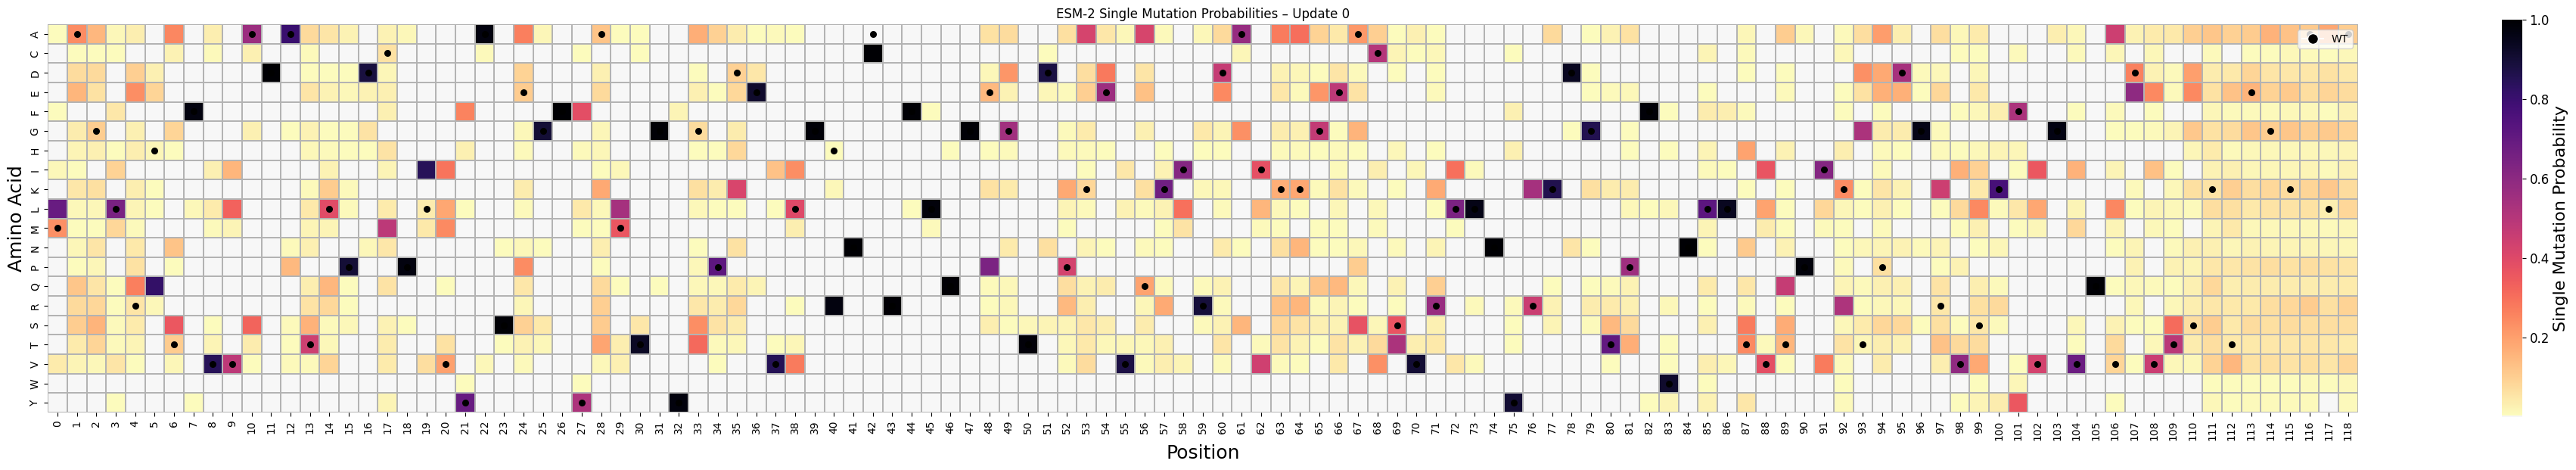

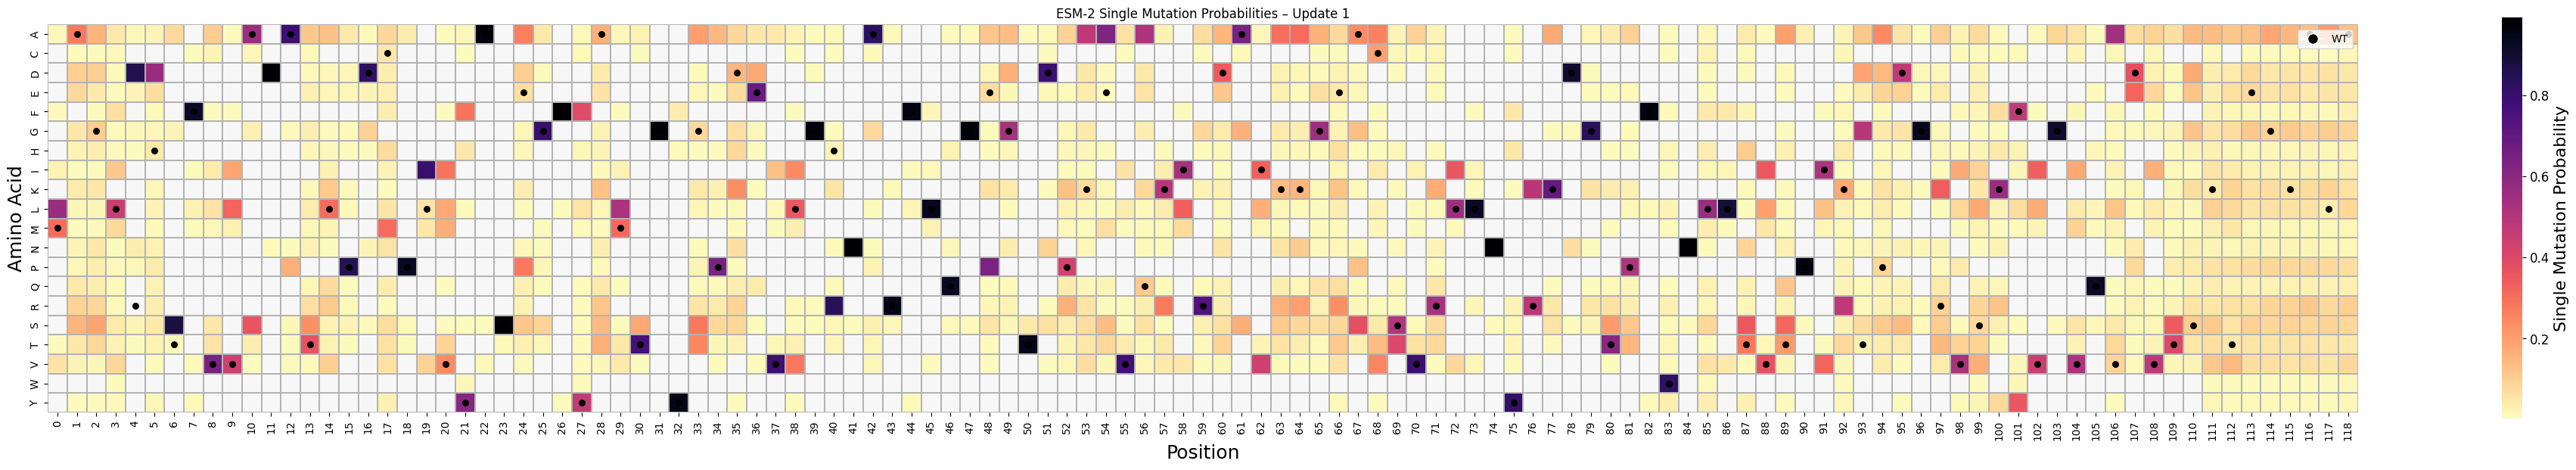

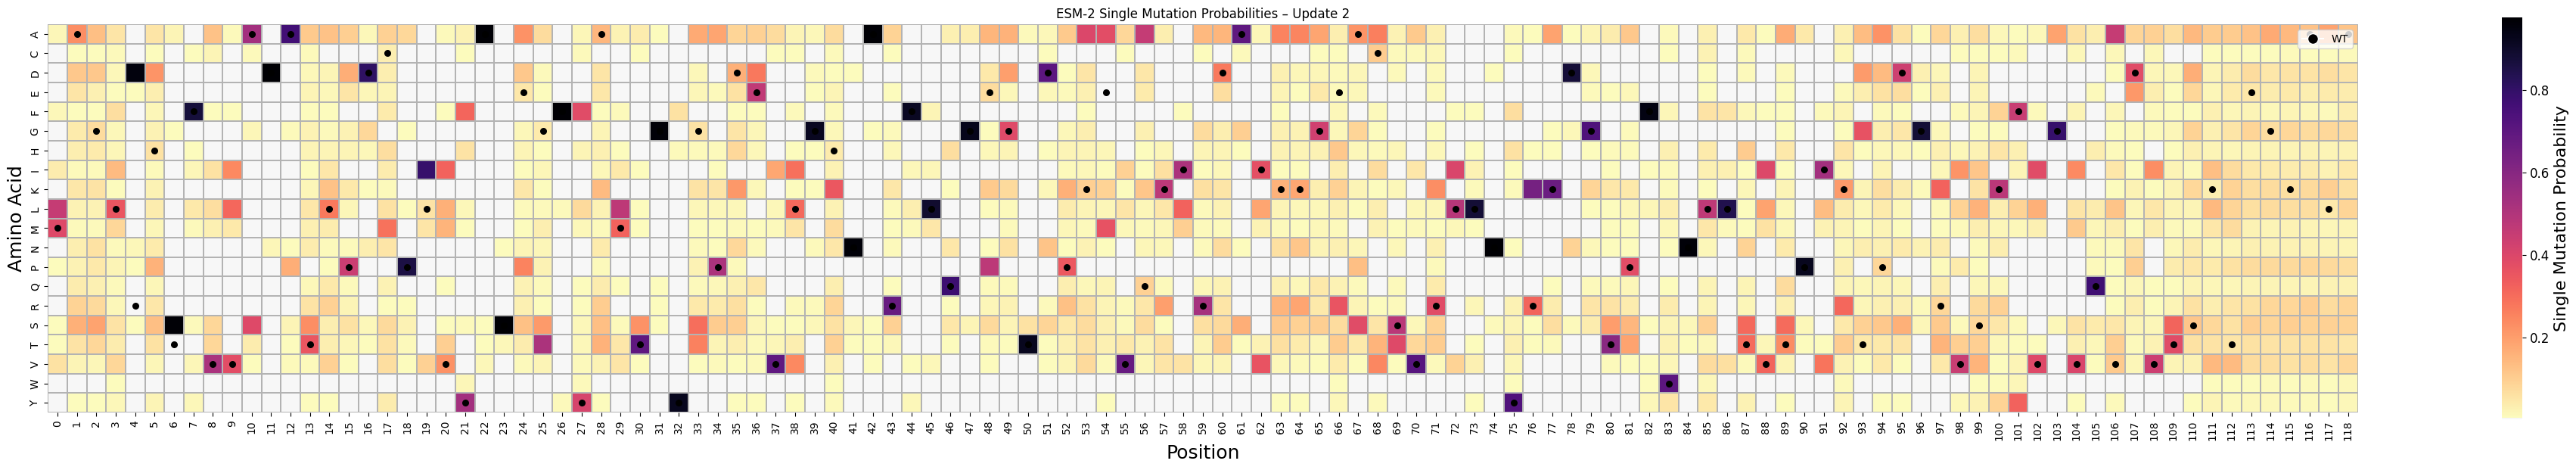

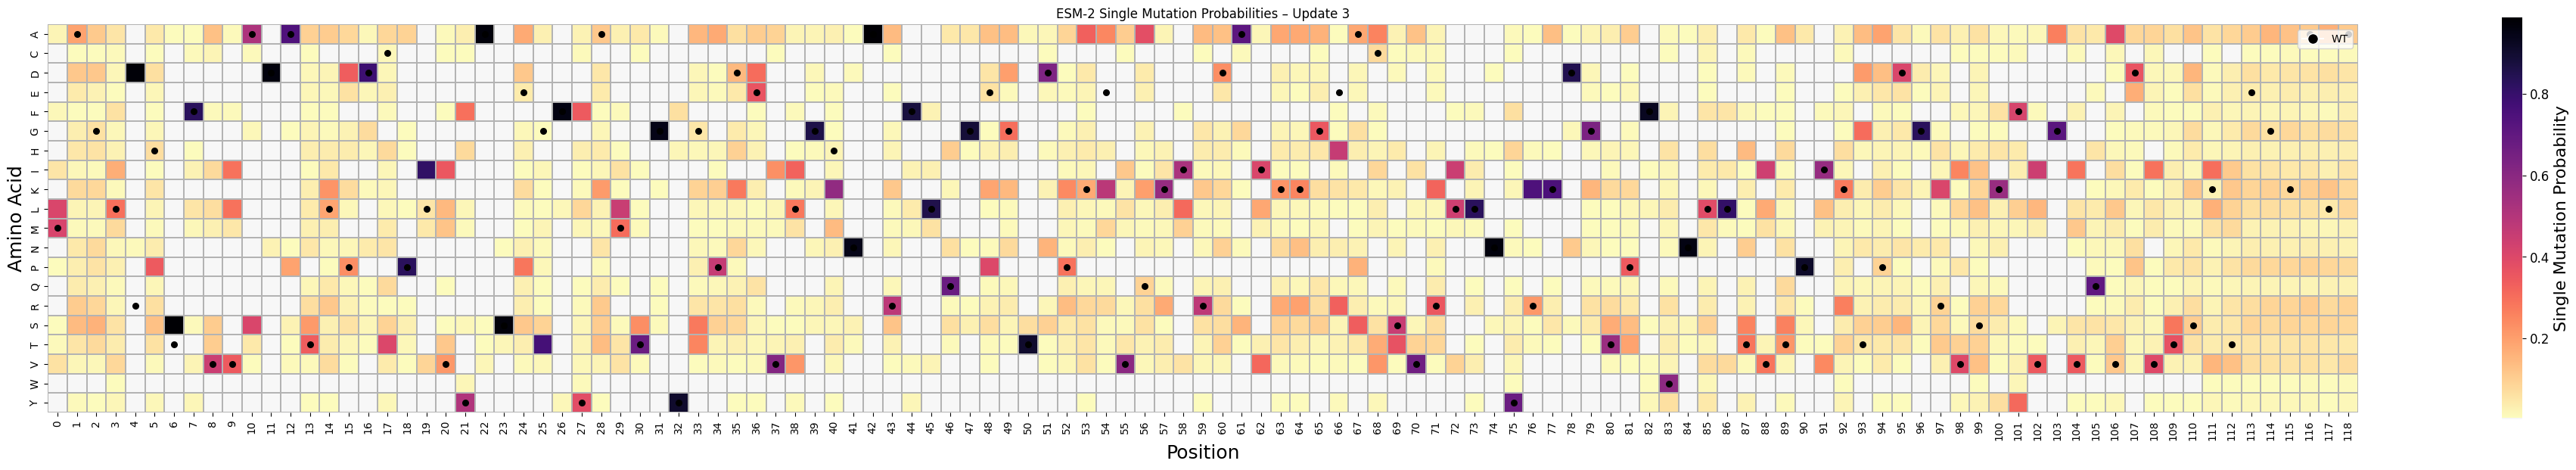

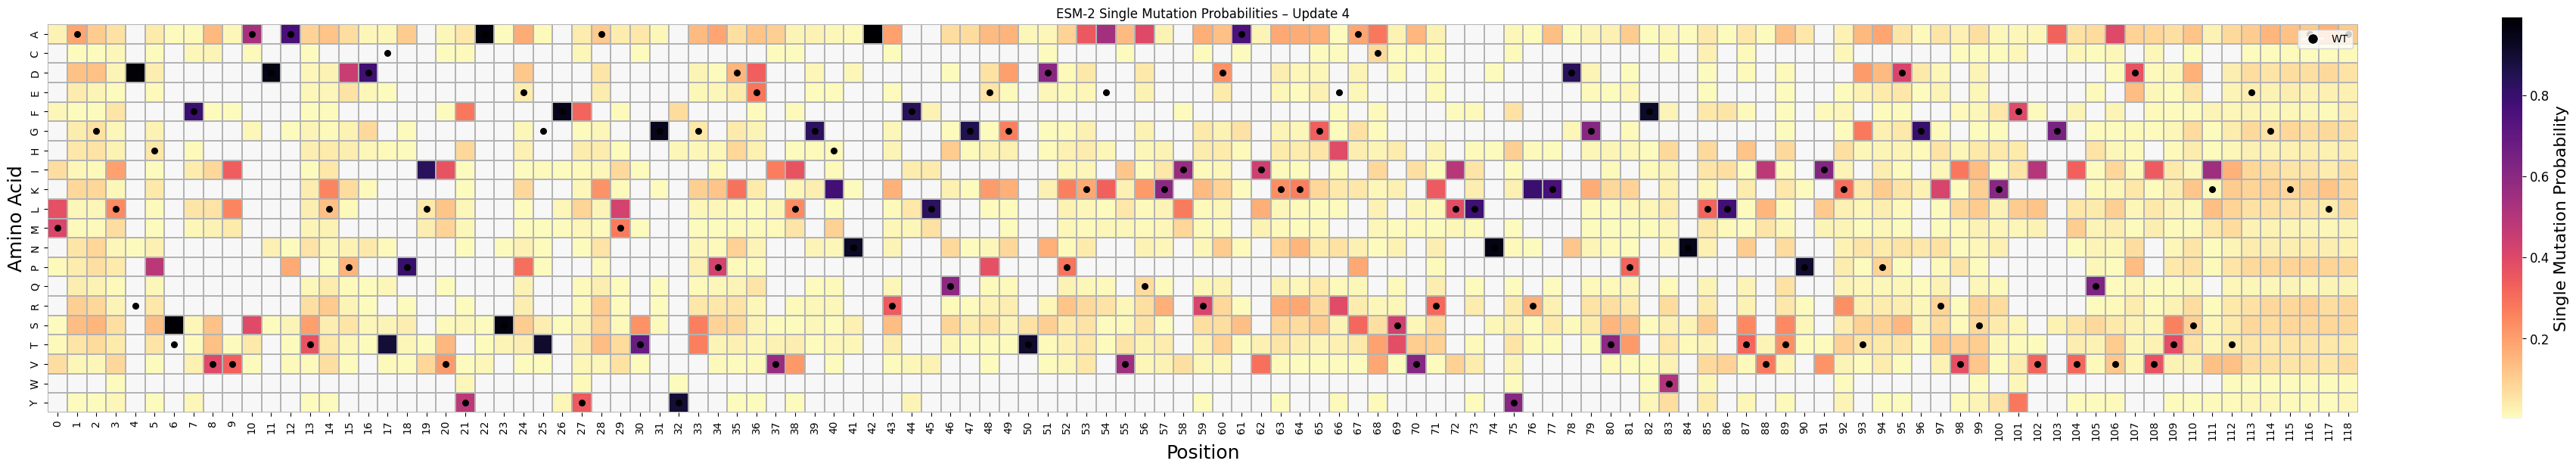

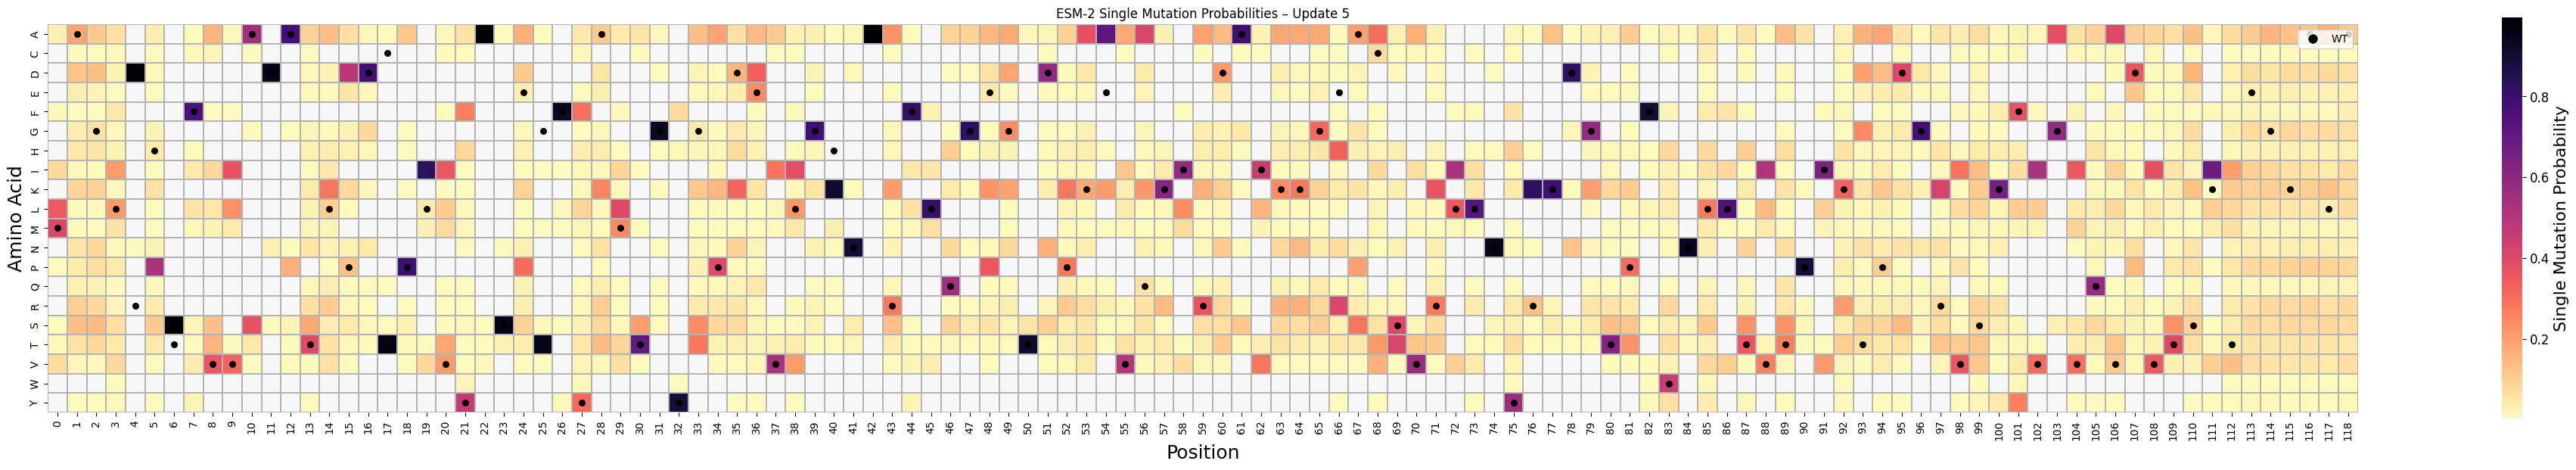

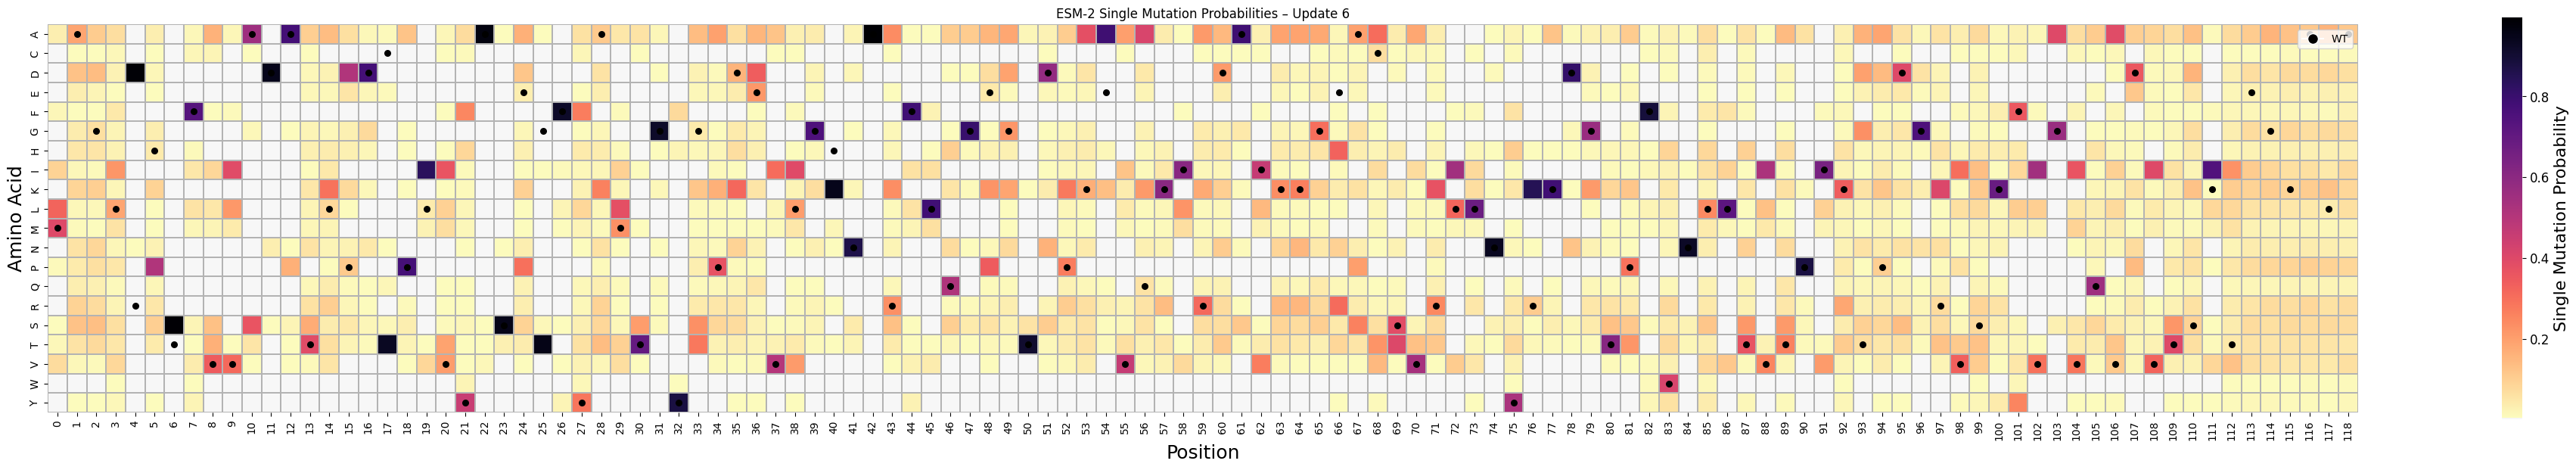

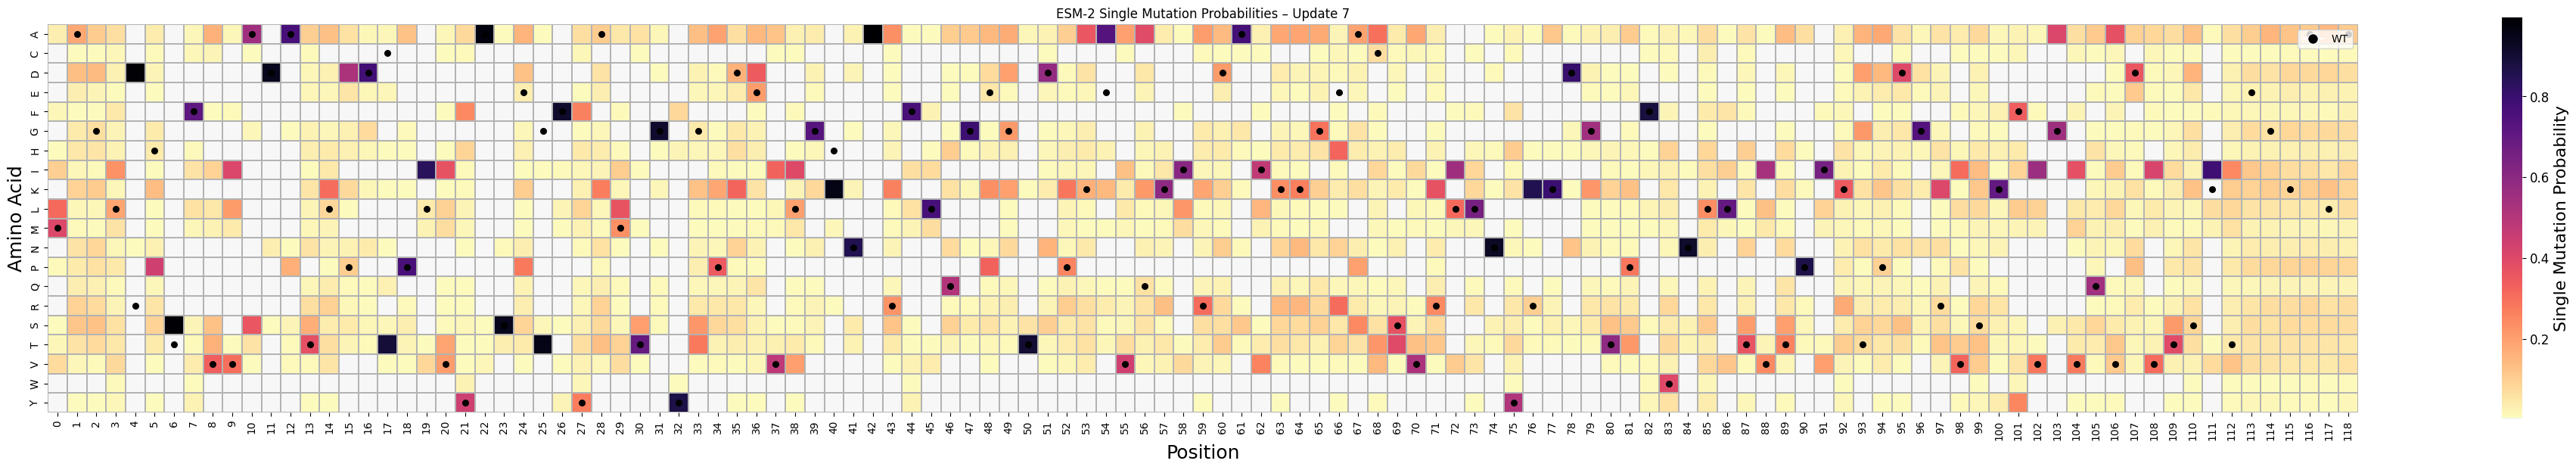

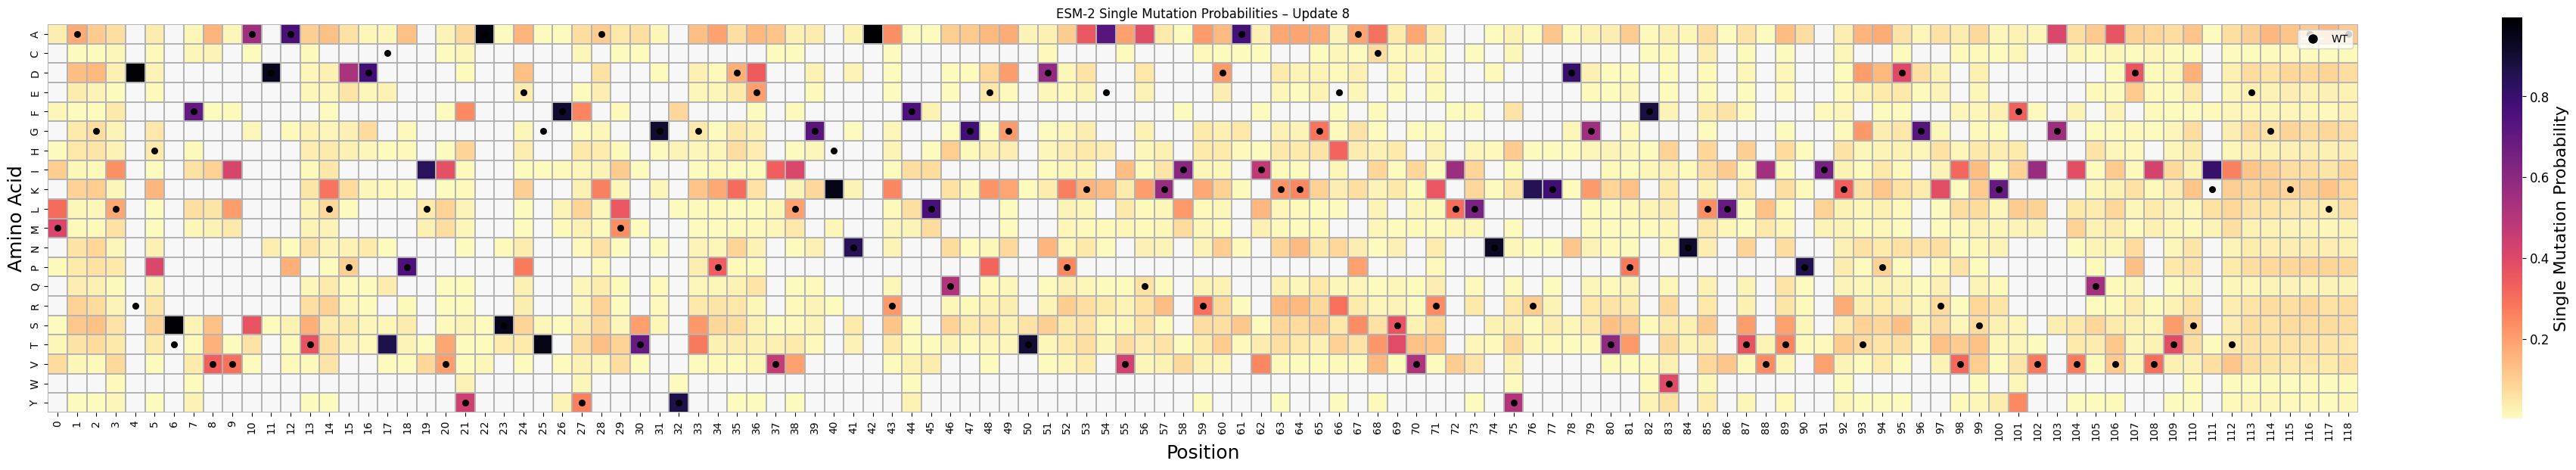

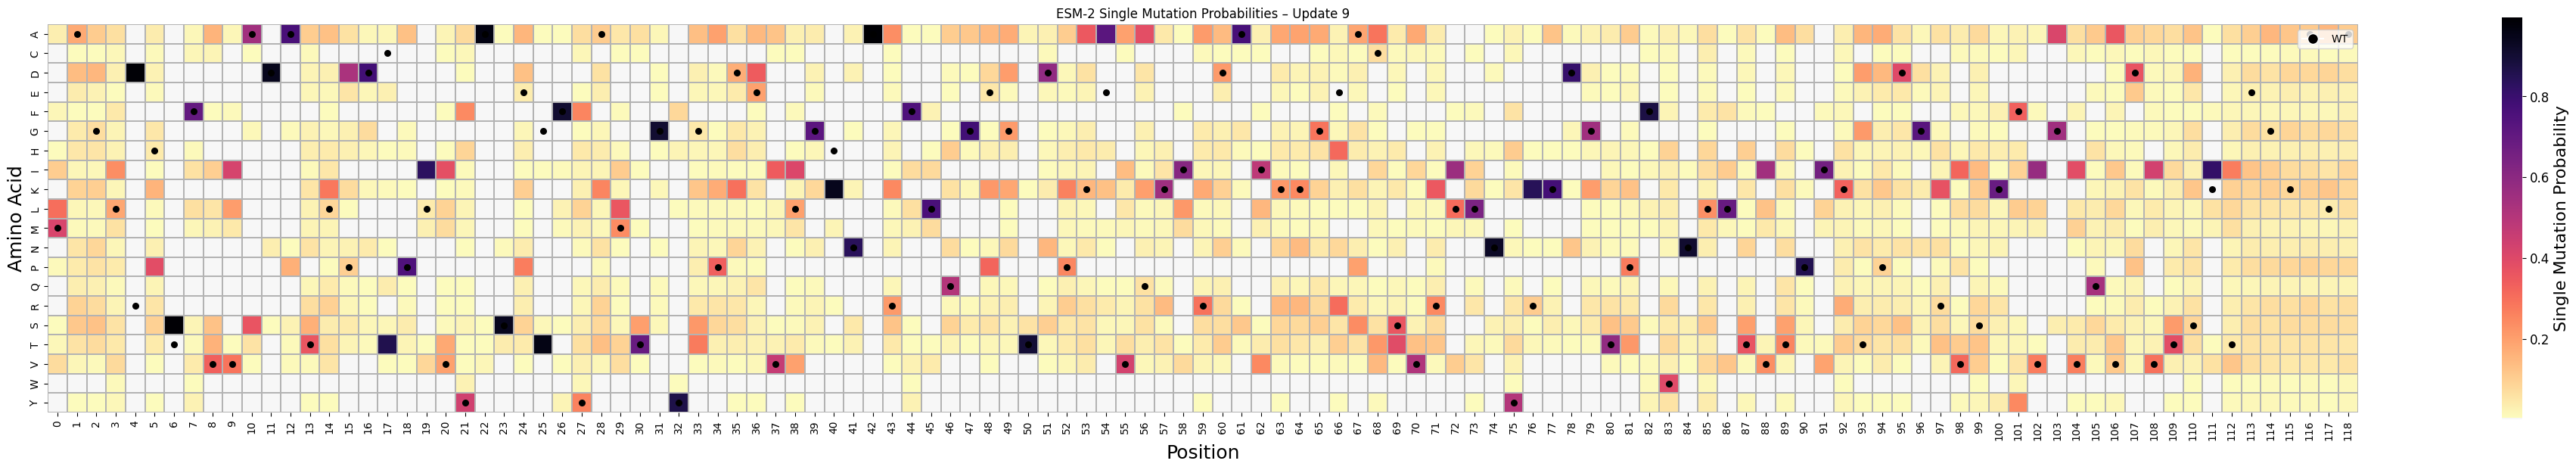

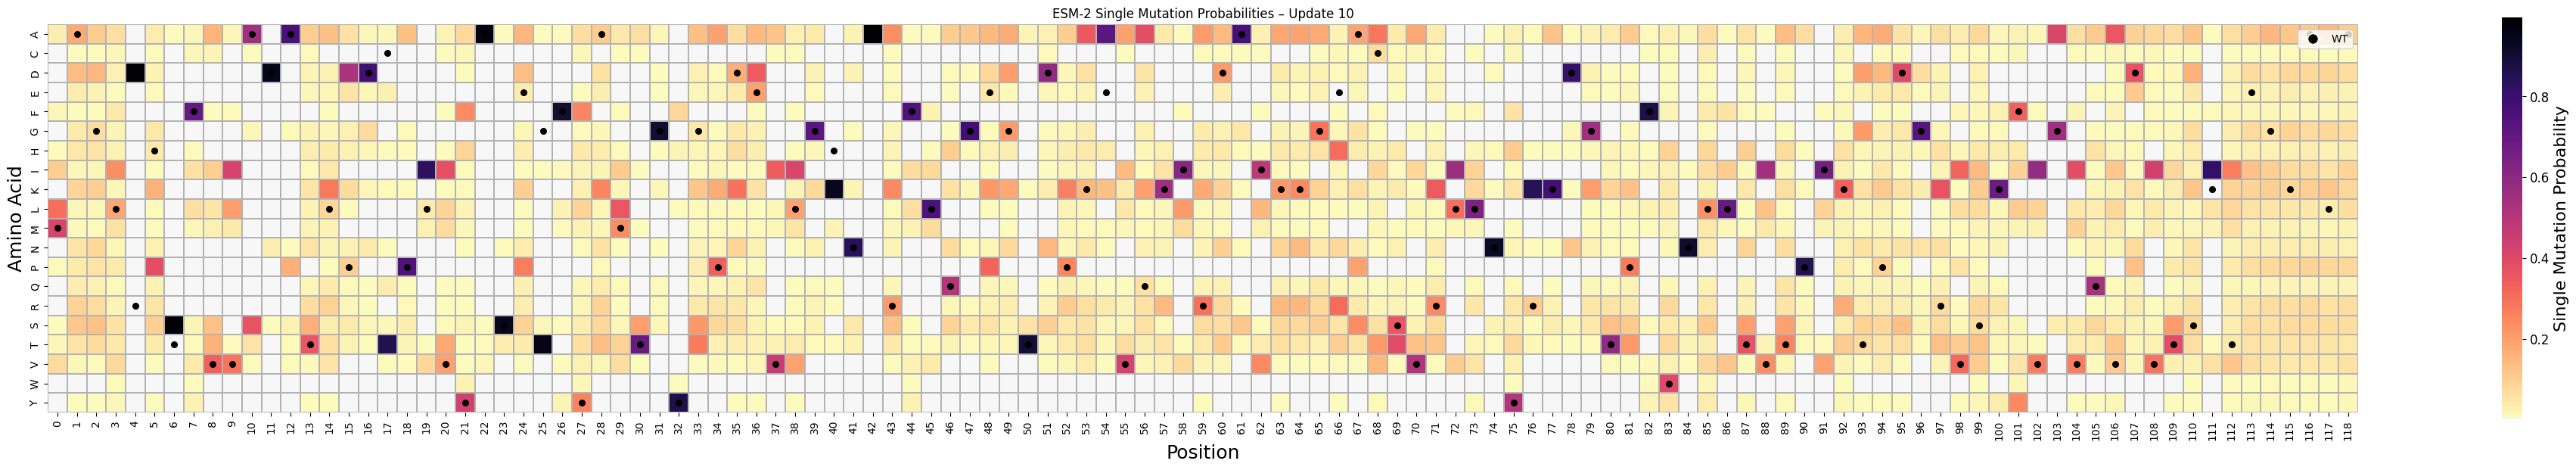

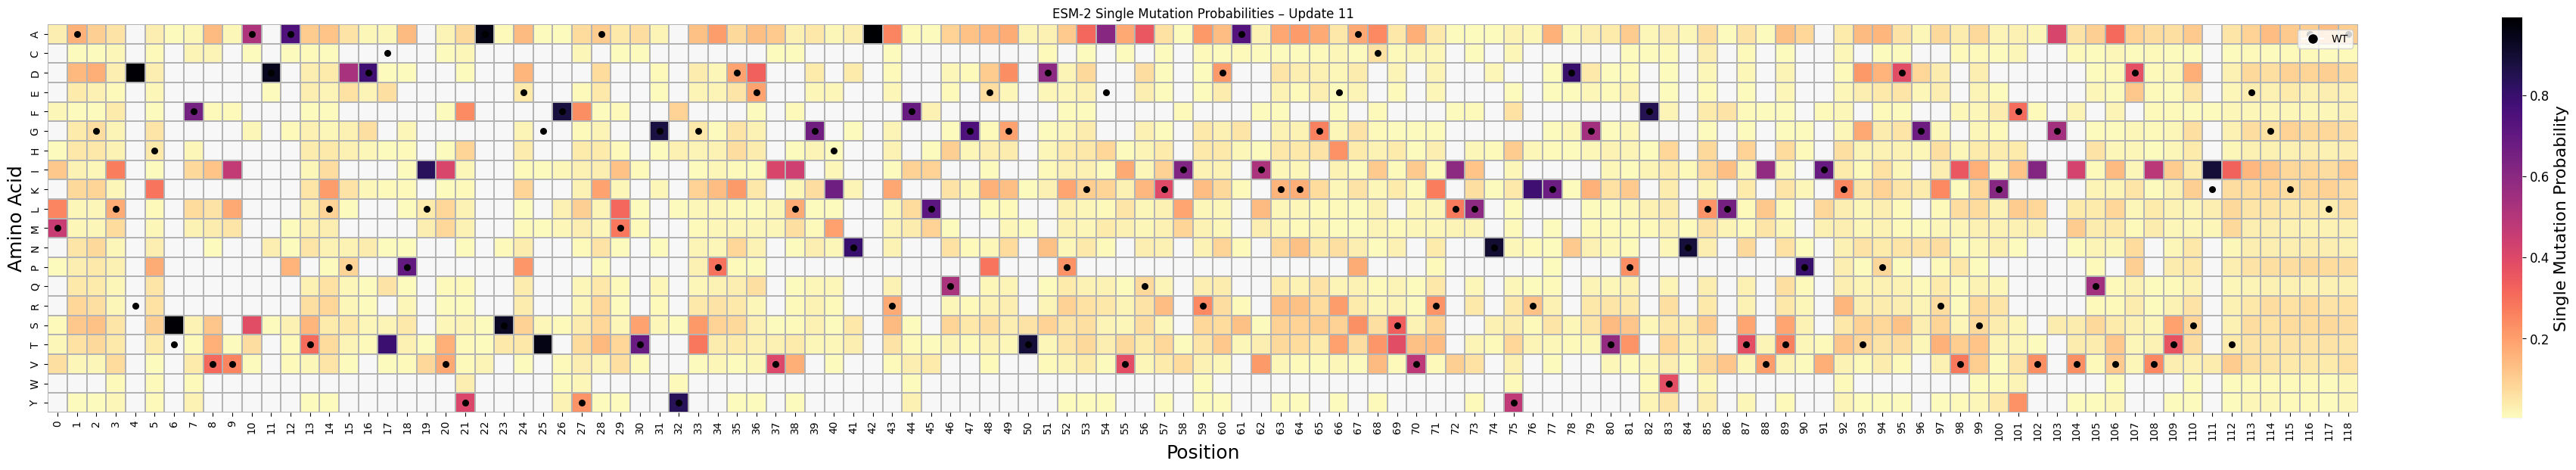

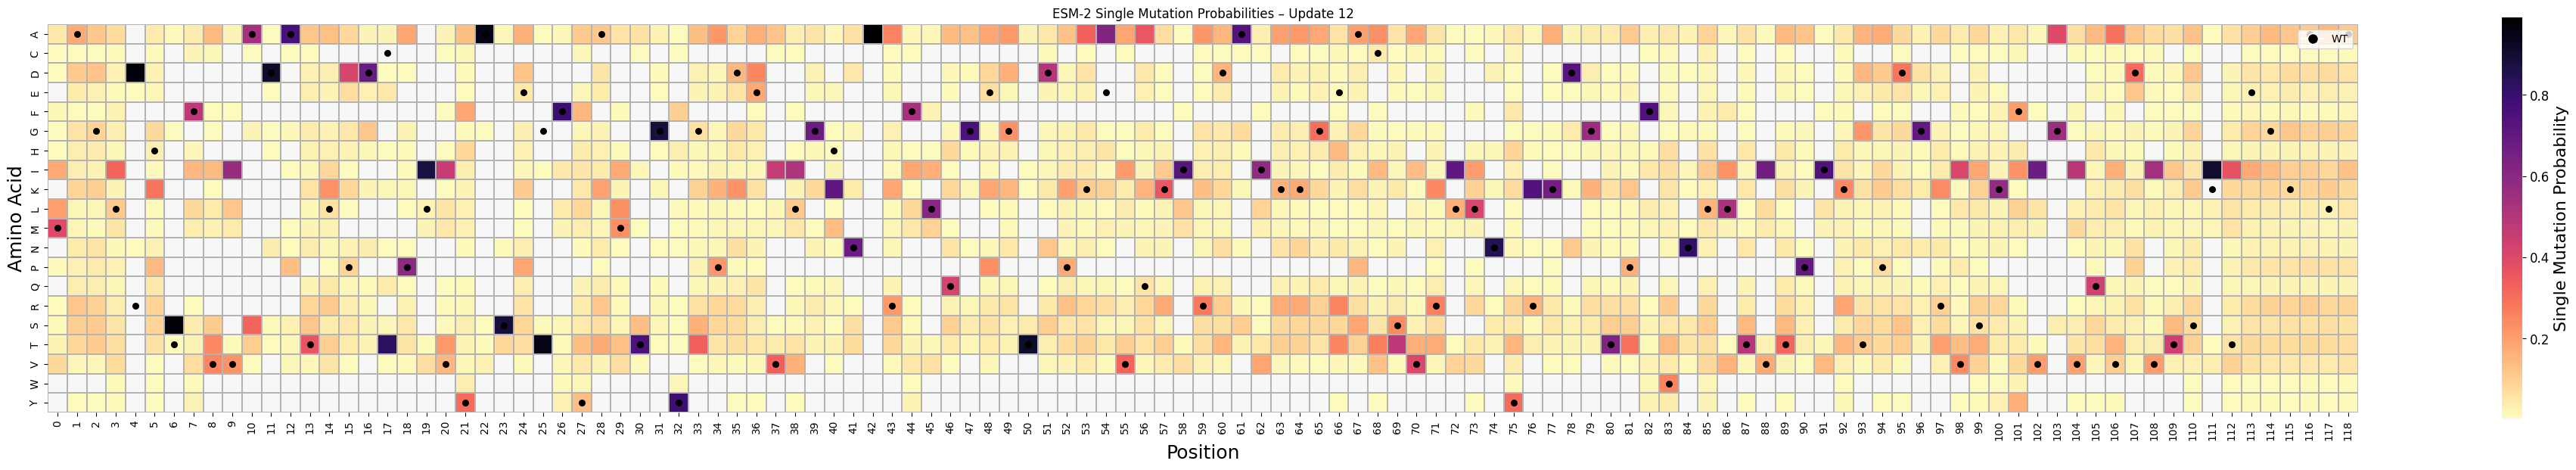

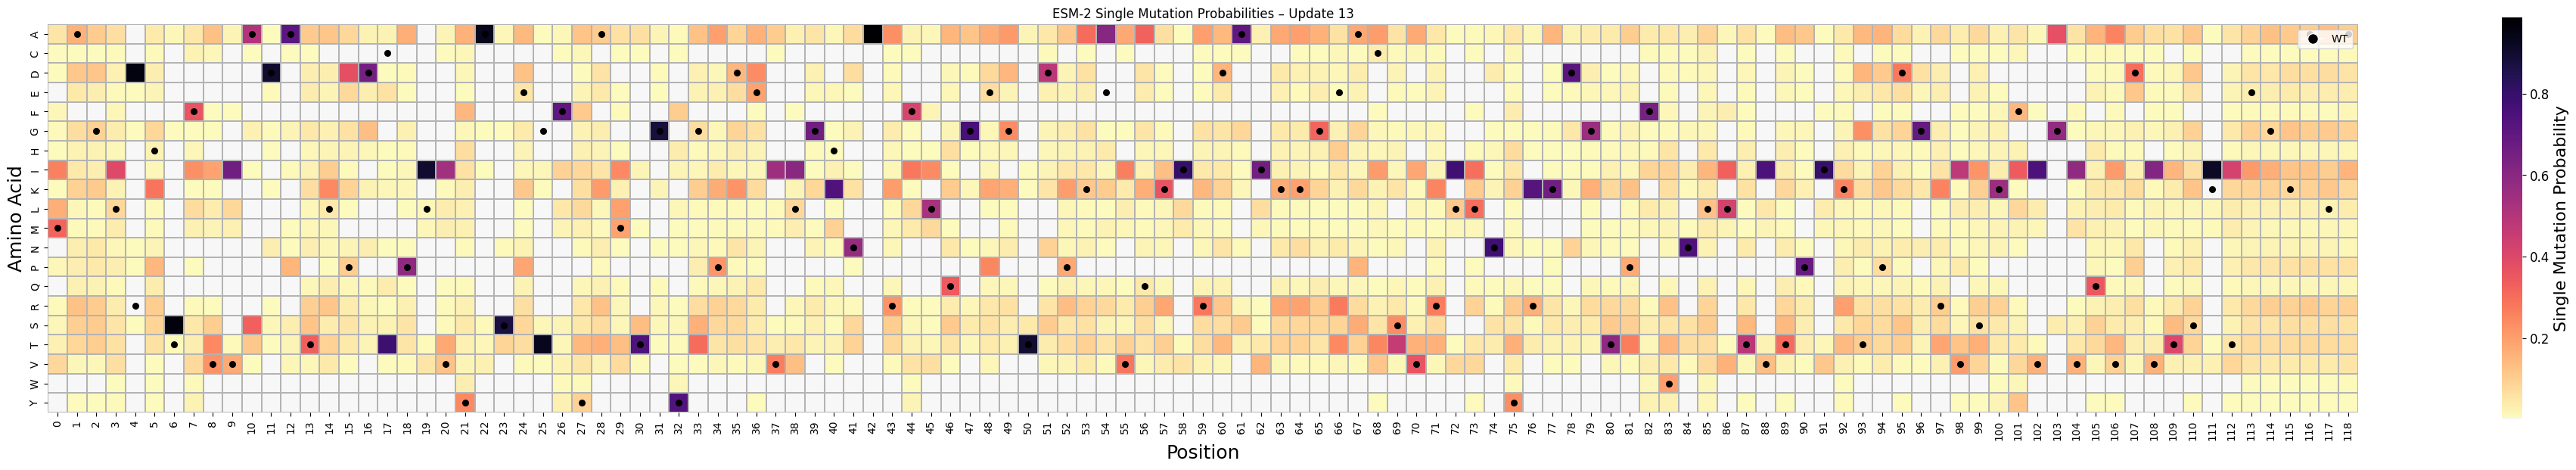

In [10]:
# Obtain single mutant probabilities for ESM-2 at each step of training
num_updates = 14
location = "../RLXF_PPO_from_pretrained_ESM2_GPU/SM_probability_data"
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
all_tokens = list(tokenizer.get_vocab().keys())[4:24]  # ESM2 amino acid tokens
esm2_to_AAs_row_order = [all_tokens.index(aa) for aa in AAs]

# Step 2: Loop over all updates to load matrices and save them in the same format as MSA and plot heatmap
for update in range(num_updates):
    npy_path = os.path.join(location, f"update_{update}_probabilities.npy")
    matrix = np.load(npy_path).T  # shape: (20, L) in ESM2 order

    # Reorder rows to match AAs
    reordered_matrix = matrix[esm2_to_AAs_row_order, :]

    # Save reordered matrix
    out_npy = os.path.join(output_dir, f"update_{update}_reordered_prob_matrix.npy")
    np.save(out_npy, reordered_matrix)

    # Plot heatmap
    plt.figure(figsize=(sequence_length // 3, 6))
    heatmap = sns.heatmap(reordered_matrix, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Single Mutation Probability', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
    pos = cbar.ax.get_position()
    cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    plt.yticks(np.arange(len(AAs)) + 0.5, list(AAs))
    plt.xlabel('Position', fontsize=18)
    plt.ylabel('Amino Acid', fontsize=18)
    plt.title(f"ESM-2 Single Mutation Probabilities – Update {update}")

    # Overlay WT residues
    for pos, aa in enumerate(WT):
        if aa in AAs:
            aa_index = AAs.index(aa)
            plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)

    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')],
        loc='upper right'
    )

    # Save heatmap
    heatmap_path = os.path.join(output_dir, f"update_{update}_heatmap.png")
    plt.tight_layout()
    # plt.savefig(heatmap_path, dpi=300)
    plt.show()
    

4.149827075004578


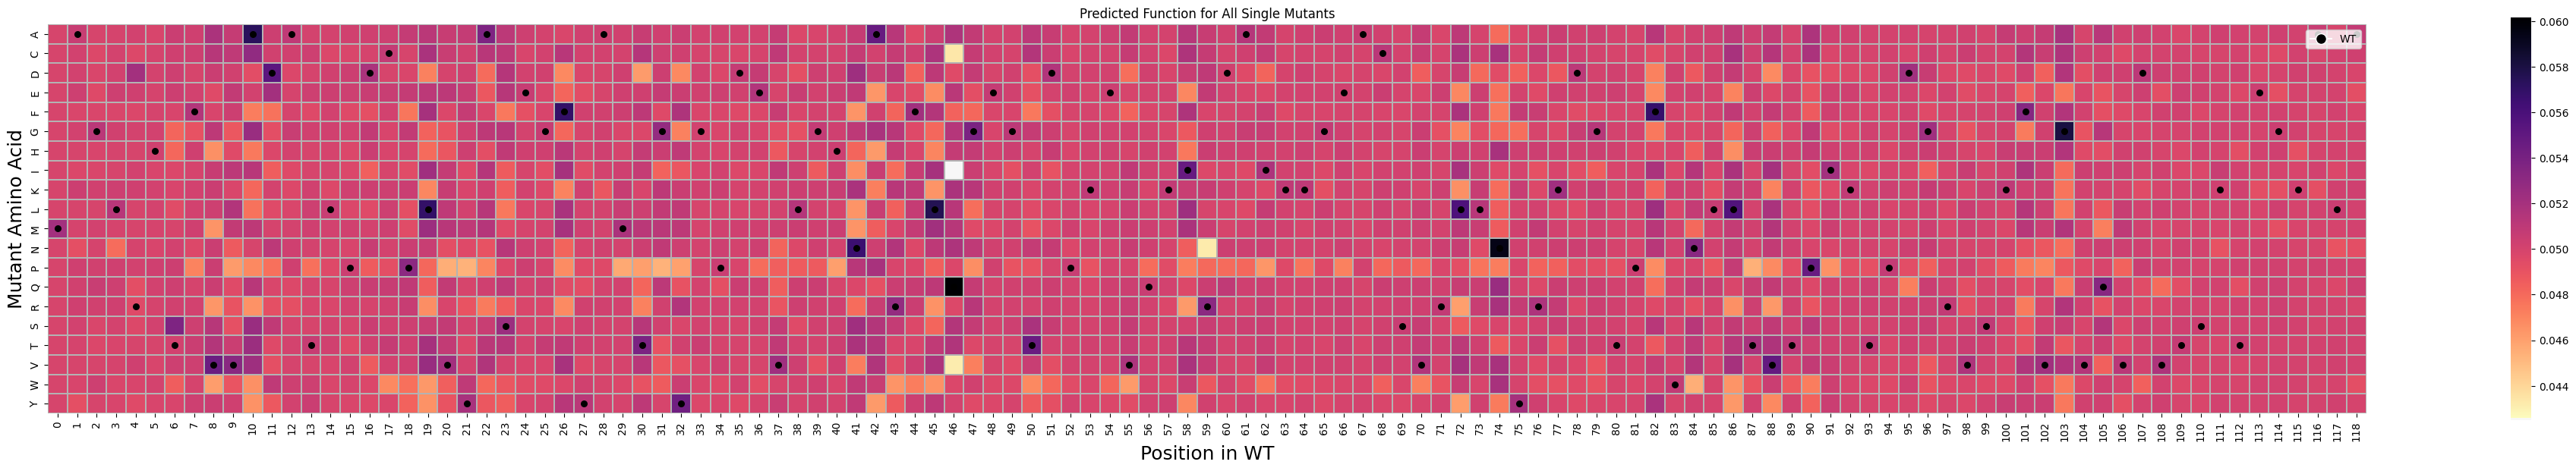

In [11]:
# Obtain predicted function for all single mutations to WT from ensemble of reward models

# Load models
models = []
for i in range(num_models):
    model = MLP(learning_rate=0.001, batch_size=32, epochs=50, slen=sequence_length)
    model_path = f'/Users/nathanielblalock/Desktop/RLXF_Projects/saved_models/MLP_reward_models/best_model_v{i}.ckpt'
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    models.append(model)

# Score the WT sequence as a whole
WT_tensor = torch.tensor(aa2ind(list(WT)))
wt_scores = [model.predict(WT_tensor).item() for model in models]
WT_score = np.percentile(wt_scores, 5)
print(WT_score)

# Step 2: Score all single mutants of WT
heatmap_matrix = np.zeros((20, sequence_length))

for pos in range(sequence_length):
    for aa_idx, aa in enumerate(AAs):

        mutant_seq = list(WT)
        mutant_seq[pos] = aa
        ind_seq = torch.tensor(aa2ind(mutant_seq))

        scores = []
        for model in models:
            score = model.predict(ind_seq).item()
            scores.append(score)

        functional_score = np.percentile(scores, 5)
        heatmap_matrix[aa_idx, pos] = functional_score - WT_score

# # Subtract WT score from all entries and normalize
heatmap_matrix = softmax(heatmap_matrix, axis=0)  # AA-wise softmax per position

# Plot normalized heatmap
plt.figure(figsize=(sequence_length // 3, 6))
sns.heatmap(heatmap_matrix, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')

# Overlay WT residues
for pos, aa in enumerate(WT):
    if aa in AAs:
        aa_index = AAs.index(aa)
        plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')],
    loc='upper right'
)

plt.yticks(np.arange(20) + 0.5, list(AAs))
plt.xlabel('Position in WT', fontsize=18)
plt.ylabel('Mutant Amino Acid', fontsize=18)
plt.title('Predicted Function for All Single Mutants')
plt.tight_layout()
plt.savefig("figures/single_mutant_function_predictions.png", dpi=300)
plt.show()

# Save matrix
np.save("figures/single_mutant_function_predictions.npy", heatmap_matrix)


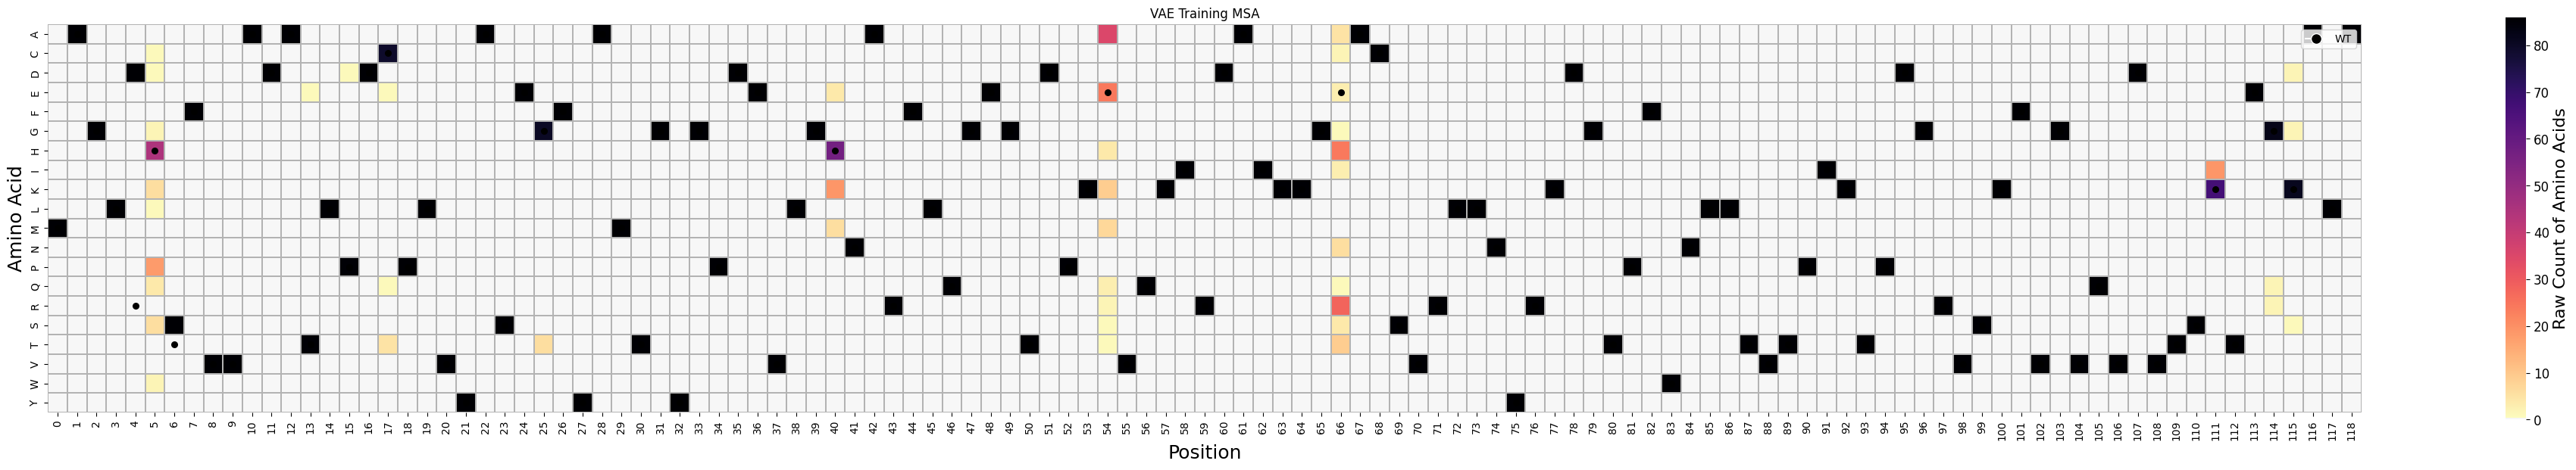

In [12]:
# Step 1: Obtain SFT sequences
SFT_dataset_path = "../RLXF_SFT_from_pretrained_ESM2_GPU/SFT_dataset_df_max_fitness_unique_designs_from_SA.pkl"
training_df = pd.read_pickle(SFT_dataset_path)

# Step 2: Count AAs per position across training sequences for all amino acids (ignore gap -)
alignment = tuple(zip(*training_df.Sequence))
AA_count = np.array([[sum(1 for aa_at_pos in alignment[pos] if aa_at_pos == aa) for aa in AAs] for pos in range(len(WT))])  # shape: (L, 20)
AA_count = AA_count.T

# # Normalize each column to sum to 1 (i.e., probability distribution over AAs at each position)
# col_sums = AA_count.sum(axis=0, keepdims=True)
# col_sums[col_sums == 0] = 1  # Prevent division by zero
# AA_count = AA_count / col_sums  # shape: (20, L)

# Step 3: Plot heatmap
plt.figure(figsize=(len(WT) // 3, 6))
heatmap = sns.heatmap(AA_count, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Raw Count of Amino Acids', fontsize=16)
cbar.ax.tick_params(labelsize=12)
pos = cbar.ax.get_position()
cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
plt.yticks(np.arange(len(AAs)) + 0.5, AAs)
plt.xlabel('Position', fontsize=18)
plt.ylabel('Amino Acid', fontsize=18)
plt.title("VAE Training MSA")

# Step 5: Annotate WT positions with black dots
for pos, aa in enumerate(WT):
    if aa in AAs:
        aa_index = AAs.index(aa)
        plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')],
           loc='upper right')

# Save and show
plt.tight_layout()
plt.savefig("figures/simulated_annealing_sequences.png", dpi=300)
plt.show()
# plt.close()

# save the matrix
AA_count_df = pd.DataFrame(AA_count)
np.save("figures/simulated_annealing_sequences.npy", AA_count)


In [13]:
# Matrix filenames
matrix_filenames = [
    # 'MSA_training_amino_acid_count_matrix.npy',
    # 'MSA_val_amino_acid_count_matrix.npy',
    # 'MSA_test_amino_acid_count_matrix.npy',
    'Natural_CreiLOV.npy',
    'VAE_prob_matrix.npy',
    # 'aligned_VAE_prob_matrix.npy',
    'update_0_reordered_prob_matrix.npy',
    'update_1_reordered_prob_matrix.npy',
    'update_2_reordered_prob_matrix.npy',
    'update_3_reordered_prob_matrix.npy',
    'update_4_reordered_prob_matrix.npy',
    'update_5_reordered_prob_matrix.npy',
    'update_6_reordered_prob_matrix.npy',
    'update_7_reordered_prob_matrix.npy',
    'update_8_reordered_prob_matrix.npy',
    'update_9_reordered_prob_matrix.npy',
    'update_10_reordered_prob_matrix.npy',
    'update_11_reordered_prob_matrix.npy',
    'update_12_reordered_prob_matrix.npy',
    'update_13_reordered_prob_matrix.npy',
    # 'simulated_annealing_sequences.npy',
    'single_mutant_function_predictions.npy'
]

input_dir = "figures"
output_dir = "figures/predicted_matrices"
os.makedirs(output_dir, exist_ok=True)

# Load and flatten all matrices
matrix_data = [np.load(os.path.join(input_dir, fname)).reshape(-1) for fname in matrix_filenames]
matrix_shape = np.load(os.path.join(input_dir, matrix_filenames[0])).shape

# Identify target
target_name = 'update_0_reordered_prob_matrix.npy'
target_idx = matrix_filenames.index(target_name)
y = matrix_data[target_idx]

# Store regression results and predicted matrices
results = {}
predicted_matrices = []

for i, (fname, x) in enumerate(zip(matrix_filenames, matrix_data)):
    
    # Perform linear regression: y ≈ m * x + b
    m, b = np.polyfit(x, y, deg=1)
    y_pred = m * x + b
    y_pred_matrix = y_pred.reshape(matrix_shape)
    predicted_matrices.append(y_pred_matrix)

    # Compute R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot

    results[fname] = {'slope': m, 'intercept': b, 'r2': r2}

# Print regression metrics
print(f"Linear regression results for predicting {target_name} from each matrix:")
for fname, stats in results.items():
    print(f"{fname}: slope = {stats['slope']:.4f}, intercept = {stats['intercept']:.4f}, R² = {stats['r2']:.4f}")


Linear regression results for predicting update_0_reordered_prob_matrix.npy from each matrix:
Natural_CreiLOV.npy: slope = 0.5258, intercept = 0.0237, R² = 0.5503
VAE_prob_matrix.npy: slope = 0.5777, intercept = 0.0226, R² = 0.5893
update_0_reordered_prob_matrix.npy: slope = 1.0000, intercept = 0.0000, R² = 1.0000
update_1_reordered_prob_matrix.npy: slope = 1.0063, intercept = -0.0003, R² = 0.8895
update_2_reordered_prob_matrix.npy: slope = 1.0410, intercept = -0.0021, R² = 0.8085
update_3_reordered_prob_matrix.npy: slope = 1.0241, intercept = -0.0012, R² = 0.7450
update_4_reordered_prob_matrix.npy: slope = 0.9763, intercept = 0.0012, R² = 0.6832
update_5_reordered_prob_matrix.npy: slope = 0.9477, intercept = 0.0026, R² = 0.6445
update_6_reordered_prob_matrix.npy: slope = 0.9421, intercept = 0.0029, R² = 0.6231
update_7_reordered_prob_matrix.npy: slope = 0.9457, intercept = 0.0027, R² = 0.6146
update_8_reordered_prob_matrix.npy: slope = 0.9496, intercept = 0.0025, R² = 0.6118
update_9_

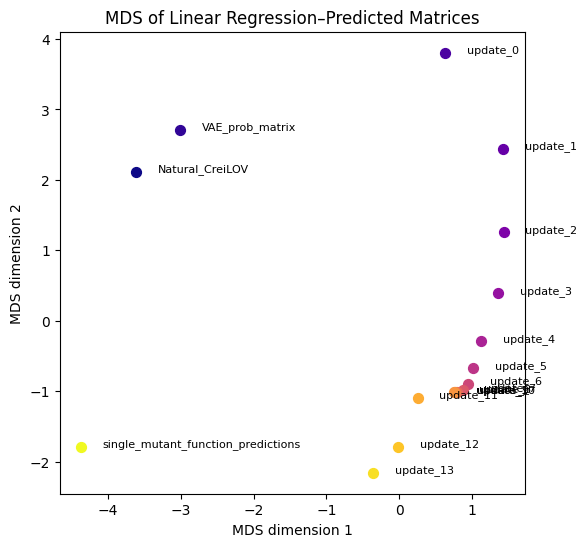

In [14]:
# # Remove the first matrix
# predicted_matrices = predicted_matrices[1:]
# matrix_filenames = matrix_filenames[1:]

# Compute distances between predicted matrices
flattened = [mat.reshape(-1) for mat in predicted_matrices]
distance_matrix = pairwise_distances(flattened, metric='euclidean')

# Run MDS on distance matrix
RS = 9
embedding = MDS(n_init=10, dissimilarity="precomputed", random_state=RS, normalized_stress='auto')
X = embedding.fit_transform(distance_matrix)

# Save MDS coordinates
np.save('figures/MDS_coordinates_for_SM_matrices.npy', X)

# Plot MDS
labels = [fname.replace('_reordered_prob_matrix.npy', '').replace('.npy', '') for fname in matrix_filenames]
colors = plt.cm.plasma(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    plt.scatter(X[i, 0], X[i, 1], color=colors[i], s=50)
    plt.text(X[i, 0] + 0.3, X[i, 1], label, fontsize=8)

plt.xlabel("MDS dimension 1")
plt.ylabel("MDS dimension 2")
plt.title("MDS of Linear Regression–Predicted Matrices")
# plt.xlim([-8, 8])
# plt.ylim([-8, 8])
# plt.tight_layout()

# Save and/or show plot
plt.savefig('figures/MDS_plot_from_predicted_matrices.svg')
plt.savefig('figures/MDS_plot_from_predicted_matrices.png')
plt.show()

In [15]:
# # UMAP
# X = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1, metric='euclidean', random_state=RS).fit_transform(flattened)

# # Save MDS coordinates
# np.save('figures/UMAP_coordinates_for_SM_matrices.npy', X)

# # Plot MDS
# labels = [fname.replace('_reordered_prob_matrix.npy', '').replace('.npy', '') for fname in matrix_filenames]
# colors = plt.cm.plasma(np.linspace(0, 1, len(labels)))

# plt.figure(figsize=(8, 8))
# for i, label in enumerate(labels):
#     plt.scatter(X[i, 0], X[i, 1], color=colors[i], s=50)
#     plt.text(X[i, 0] + 0.1, X[i, 1], label, fontsize=8)

# plt.xlabel("UMAP dimension 1")
# plt.ylabel("UMAP dimension 2")
# plt.tight_layout()

# # Save and/or show plot
# plt.savefig('figures/UMAP_plot_from_predicted_matrices.svg')
# plt.savefig('figures/UMAP_plot_from_predicted_matrices.png')
# plt.show()


In [16]:
# from scipy.special import rel_entr

# # Compute distances between predicted matrices
# flattened = [mat.reshape(-1) for mat in matrix_data]

# def symmetric_kl(P, Q):
#     P = np.clip(P, 1e-12, 1)  # Avoid log(0)
#     Q = np.clip(Q, 1e-12, 1)
#     return np.sum(rel_entr(P, Q) + rel_entr(Q, P))

# distance_matrix = np.zeros((len(flattened), len(flattened)))
# for i in range(len(flattened)):
#     for j in range(len(flattened)):
#         distance_matrix[i, j] = symmetric_kl(flattened[i], flattened[j])

# # Run MDS on distance matrix
# RS = 0
# embedding = MDS(n_init=10, dissimilarity="precomputed", random_state=RS, normalized_stress='auto')
# X = embedding.fit_transform(distance_matrix)

# # Save MDS coordinates
# np.save('figures/MDS_coordinates_for_SM_matrices.npy', X)

# # Plot MDS
# labels = [fname.replace('_reordered_prob_matrix.npy', '').replace('.npy', '') for fname in matrix_filenames]
# colors = plt.cm.plasma(np.linspace(0, 1, len(labels)))

# plt.figure(figsize=(8, 8))
# for i, label in enumerate(labels):
#     plt.scatter(X[i, 0], X[i, 1], color=colors[i], s=50)
#     plt.text(X[i, 0] + 0.05, X[i, 1] - 0.05, label, fontsize=8)

# plt.xlabel("MDS dimension 1")
# plt.ylabel("MDS dimension 2")
# plt.title("MDS of Linear Regression–Predicted Matrices")
# plt.tight_layout()

# # Save and/or show plot
# plt.savefig('figures/MDS_plot_from_predicted_matrices.svg')
# plt.savefig('figures/MDS_plot_from_predicted_matrices.png')
# plt.show()